In [2]:
import sys
import seaborn as sns
import os
import glob
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import avalanches as crfn
import admin_functions as adfn
import plot as pltfn
import scipy
from scipy import stats 
import IS as isfn
import network as netfn

sns.reset_orig()
#plt.style.use('dark_background')
%load_ext autoreload
%autoreload

# Define paths
#---------------------------------------------------------------------------
Fdrop = '/Users/dominicburrows/Dropbox/PhD/analysis/'
Fmac = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/'
Ffig = '/Users/dominicburrows/Dropbox/PhD/figures/'
Ftm = '/Volumes/Dominic Time Machine/'
experiment = 'PTZ-WILDTYPE'
savepath = Fdrop + 'Project/' + experiment + os.sep 

sys.version

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'3.8.3 (default, Jul  2 2020, 11:26:31) \n[Clang 10.0.0 ]'

# Construct network
* unconnected nodes from real fish structure
* k-means on all fish warped to same space: k = mean number of cells
* n cells - distance between cells in space

In [ ]:
#Plot all registered cells
fig,axarr = plt.subplots(figsize = (10,10))
comb_coords = np.load(reglist[0])
for i in range(len(reglist)-1):
    comb_coords = np.row_stack((comb_coords,np.load(reglist[i+1])))

spatial_conversion = [.5, .5, 15]
space_coord = np.multiply(comb_coords, spatial_conversion)
axarr.scatter(space_coord[:,0], space_coord[:,1], s = 4, color = 'black' , alpha = 0.03)
plt.show()
#How many cell clusters - mean of all cells used in av calculation
sumd = 0
for i in range(len(coordlist)):
    sumd = sumd + np.load(coordlist[i]).shape[0]
n_clust = np.int(sumd/len(coordlist))
print(str(n_clust))

In [ ]:
#Remove unwanted coords for plotting
x,y = 140, 240 
coordvec = []
for i in range(5):
    x  = x+10
    y = y-10
    xcoord = np.where(space_coord[:,0] > x)[0]
    ycoord = np.where((space_coord[:,1] > y))[0]
    coordvec = np.append(coordvec, np.intersect1d(xcoord,ycoord))
    
remaining = np.where(space_coord[:,1]< 5)
coordvec = np.append(coordvec, remaining)
coordvec = np.unique(coordvec.astype(int))

new_space_coord = np.zeros((space_coord.shape[0] - coordvec.shape[0], 3))
count=0
for i in range(space_coord.shape[0]):
    if i in coordvec:
        continue
    else:
        new_space_coord[count] = space_coord[i]
        count+=1


In [ ]:
#PLot outlier removal
fig,axarr = plt.subplots(figsize = (10,10))
axarr.scatter(space_coord[:,0], space_coord[:,1], s = 4, color = 'grey' , alpha = 0.1)
axarr.scatter(space_coord[:,0][coordvec], space_coord[:,1][coordvec], s = 4, color = 'red' , alpha = 0.1)
plt.show()

fig,axarr = plt.subplots(figsize = (10,10))
axarr.scatter(new_space_coord[:,0], new_space_coord[:,1], s = 4, color = 'grey' , alpha = 0.1)
plt.show()

sumd = 0
for i in range(len(coordlist)):
    sumd = sumd + np.load(coordlist[i]).shape[0]
n_clust = np.int(sumd/len(coordlist))
print(str(n_clust))

In [ ]:
#Kmeans clustering
from sklearn.cluster import KMeans
kmeans   = KMeans(n_clusters=n_clust, random_state=0).fit(new_space_coord)  #perform k means on all cells
klab =  kmeans.labels_
space_coord_labels = np.column_stack((new_space_coord, klab))
np.save(savepath + 'klabels-spaced-coords.npy', space_coord_labels)

In [ ]:
#Average cells by labels to make new cluster
coords = np.load(net[0])
unq = np.unique(coords[:,3]).astype(int)
node_coord = np.zeros((unq.shape[0], 3))
for i in unq:
    data = coords[np.where(coords[:,3] == unq[i])][:,:3]
    node_coord[i] = [sum(x)/len(x) for x in zip(*data)]
np.save(savepath + 'knodes-coords.npy', node_coord)

In [ ]:
fig,axarr = plt.subplots(figsize = (10,10))
coords = np.load(net[0])
axarr.scatter(coords[:,0], coords[:,1], s = 4, color = 'grey' , alpha = 0.05)
axarr.scatter(node_coord[:,0], node_coord[:,1], s = 4, color = 'red' , alpha = 0.3)
plt.show()

# Connect network

## Parameters
* k = edge density, number of nearest neighbours to connect to
* p = probability of reassigning network - p defines small worldness
* s = edge weight (probability of firing), scaled for distance
* c = cycle density, dependent on k and p


## Toy models

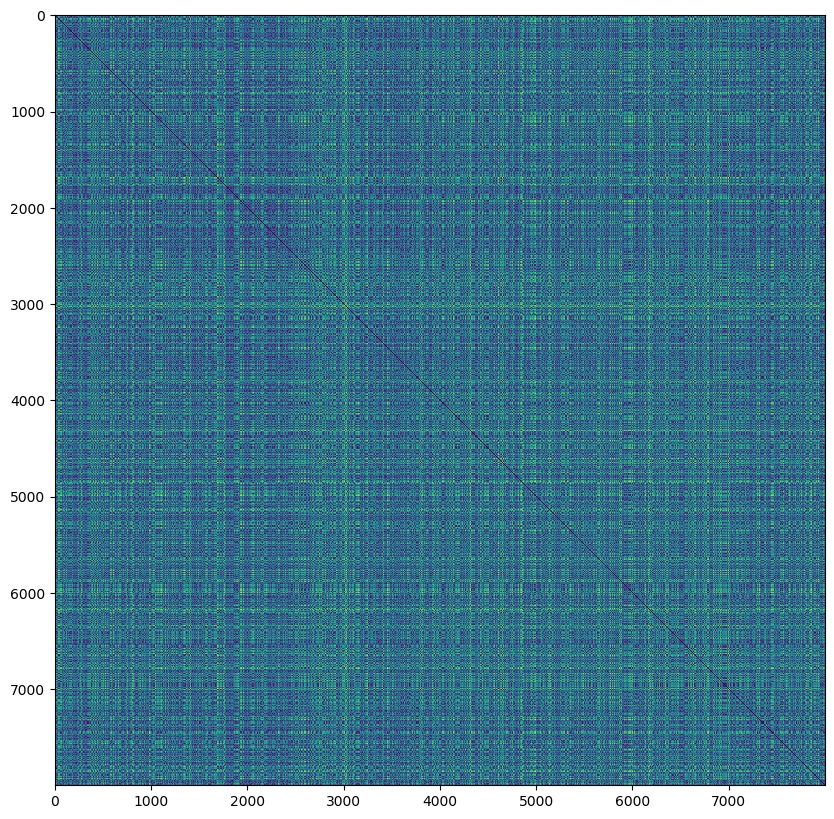

In [193]:
#Toy models
Nnodes    = 8000
cell_locs = np.random.rand(Nnodes, 2)
dist = euclidean_distances(cell_locs)
p = 0.1
k = 2/dist.shape[0]
plt.imshow(dist)
plt.show()

In [ ]:
#undirected network
sim_list = list(range(10))
cyc_list = list(range(10))

for i in range(10):
    sim = netfn.netsim(dist).ws_generate(k, p, 'directed')
    sim_list[i] = sim.A
    
    G = nx.from_numpy_matrix(sim.A)
    cyc = nx.algorithms.cycle_basis(G)
    #edge =  G.number_of_edges()
    edge = np.sum(sim.A)
    cyc_vec = np.zeros(len(cyc))
    for t in range(len(cyc)):
        cyc_vec[t] = len(cyc[t])
    cyc_un = np.unique(cyc_vec, return_counts=True)
    multi = np.multiply(cyc_un[0],cyc_un[1])
    cyc_list[i] = [np.sum(multi) , np.sum(multi)/len(cyc), len(cyc),edge]
cyc_list

In [ ]:
print(np.var([cyc_list[i][2] for i in range(len(cyc_list))]))
print(np.max(([cyc_list[i][2] for i in range(len(cyc_list))])) - np.min(([cyc_list[i][2] for i in range(len(cyc_list))])))

# Find parameter ranges
* Find optimal range of k,p,s that matches empirical data
* what combination maximises cycle variance
* k = 1 - 200 edges
* p = 0.001 - 1
* s = divisor - 200, svals - 0-3, soften - 0.07

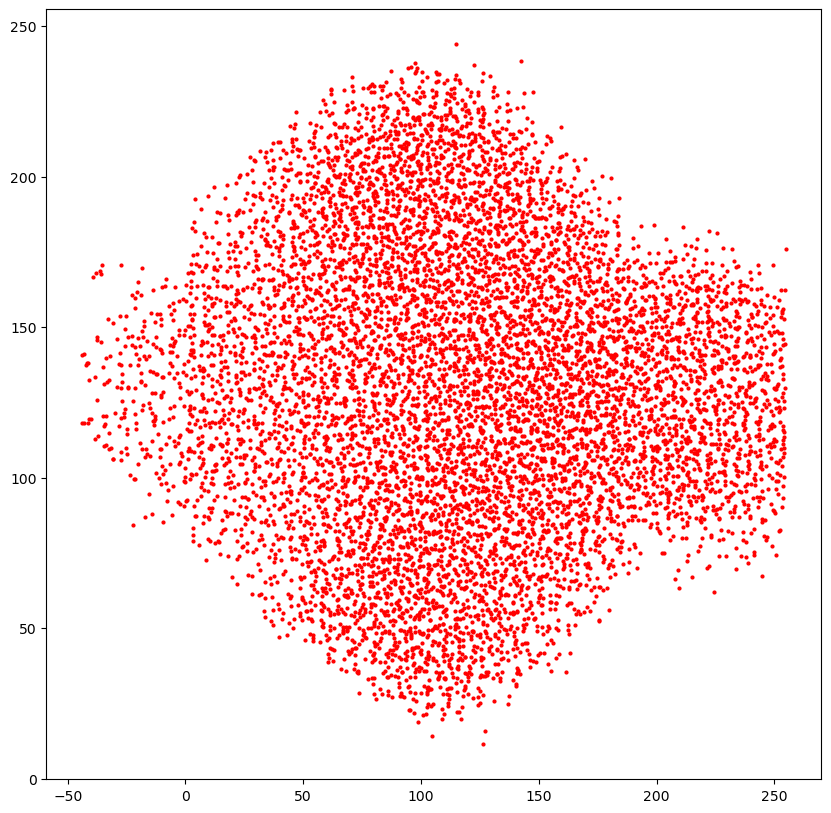

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     

# Node coordinates
#---------------------------------------------------------------------------
os.chdir(Fdrop + 'Project/' + experiment)
node = sorted(glob.glob('knodes*'))
fig,axarr = plt.subplots(figsize = (10,10))
nodes = np.load(node[0])
axarr.scatter(nodes[:,0], nodes[:,1], s = 4, color = 'red' , alpha = 1)
plt.show()

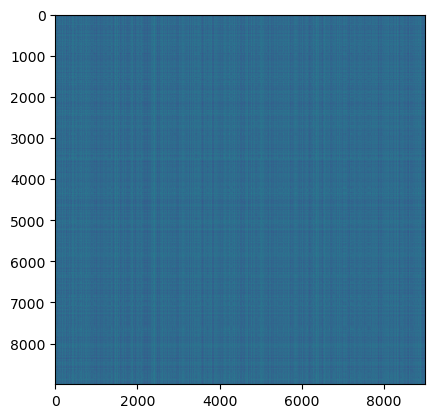

In [4]:
# K LIN + P LIN SCALE 
import numpy as np
import matplotlib.pyplot as plt
p_vals = np.array(np.append(0.001, np.linspace(0.1, 1, 11))).tolist()
k_vals = np.array(np.append(1/nodes.shape[0], [i/nodes.shape[0] for i in np.linspace(20, 200, 11)])).tolist()
cell_locs = nodes
dist = euclidean_distances(nodes)
plt.imshow(dist)
plt.show()

In [5]:
for i in range(len(k_vals)):
    print('k = ' + str(nodes.shape[0]*k_vals[i]) + ' p = ' + str(p_vals[i]))

k = 1.0 p = 0.001
k = 20.0 p = 0.1
k = 37.99999999999999 p = 0.19
k = 56.0 p = 0.28
k = 74.0 p = 0.37
k = 92.0 p = 0.45999999999999996
k = 110.0 p = 0.5499999999999999
k = 128.0 p = 0.64
k = 146.0 p = 0.73
k = 164.0 p = 0.82
k = 182.0 p = 0.9099999999999999
k = 200.0 p = 1.0


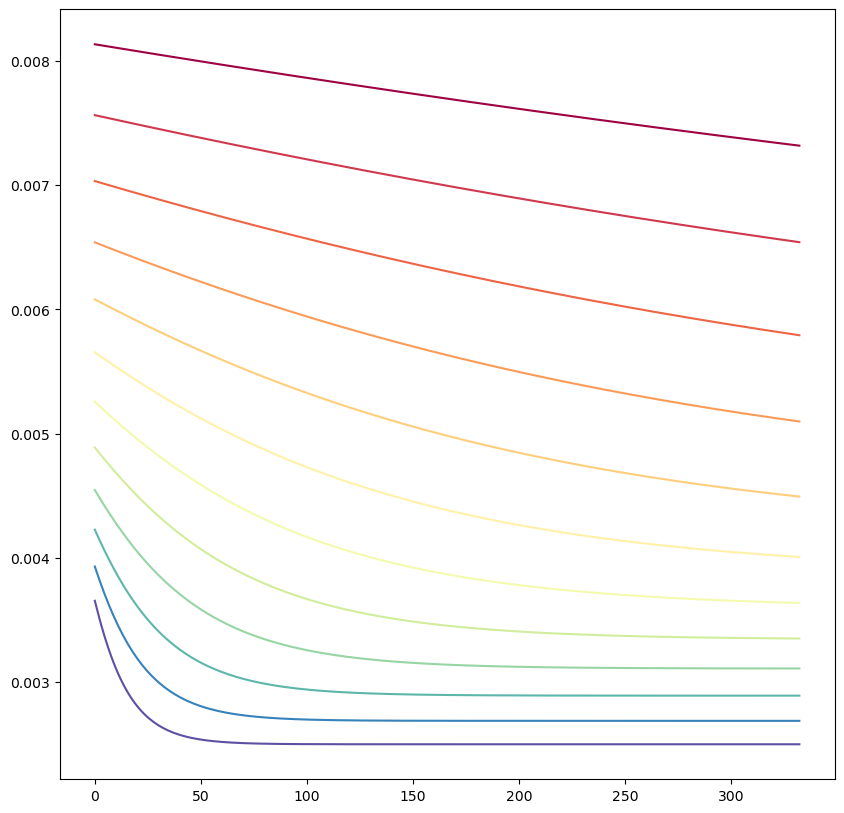

In [6]:
# Simple sigmoid function to 'soften' the exponential
#-------------------------------------------------------------------------------
def sig(x):
  return 1 / (1+np.exp(-x))

# Conversion from distance to edge weights, scaled (itself exponentially) by s
#-------------------------------------------------------------------------------
def dist2edge(distance, divisor, s):
  edgeweights = np.exp(s/5)*sig(np.exp(-soften/np.exp(s)*distance))/divisor
  return edgeweights

#S parameters
Nsteps  = 12
divisor = 200
soften = 0.07
s_vals   = np.array(np.linspace(0, 4, Nsteps)).tolist()

#Plot each s value
fig, ax = plt.subplots(1, figsize=(10,10))
colors  = cm.Spectral_r(np.linspace(0,1,Nsteps))
distance = np.linspace(0, np.max(dist), 300)
for s in range(len(s_vals)):
  ax.plot(distance, dist2edge(distance, divisor, s_vals[s]), c=colors[s])
plt.show()


### Empirical matched avalanches

In [7]:
# Choose path and create lists of coord and trace files
#---------------------------------------------------------------------------
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
blnlist = sorted(glob.glob('*BLN*_av.npy*'))
p20list = sorted(glob.glob('*PTZ20*_av.npy*'))

In [8]:
choose = 0
bln_distlist = [np.load(blnlist[i])[choose] for i in range(len(blnlist))]
p20_distlist = [np.load(p20list[i])[choose] for i in range(len(p20list))]
bln_vec = []
p20_vec = []
for i in range(len(bln_distlist)):
    bln_vec = np.append(bln_vec, bln_distlist[i])
    p20_vec = np.append(p20_vec, p20_distlist[i])

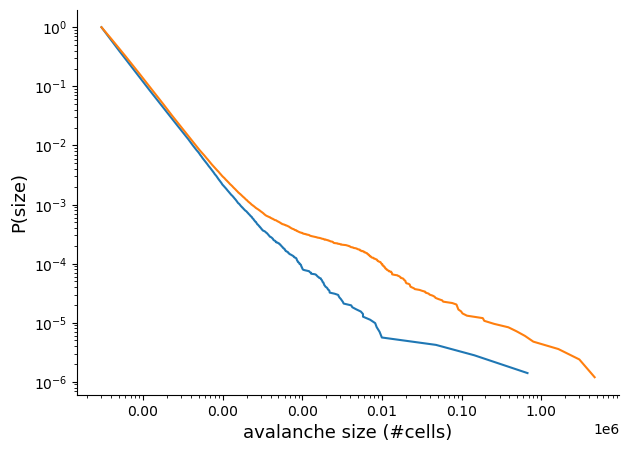

In [9]:
import matplotlib
import powerlaw
fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
avdistcut = bln_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1)
avdistcut = p20_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1)

axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

In [13]:
np.mean(bln_vec)

7.88459361962949

In [10]:
np.max(bln_vec)

673843.0

In [11]:
np.mean(p20_vec)

24.96471733844711

In [12]:
np.max(p20_vec)

4701223.0

### Cycle variance


In [38]:
# Find cycle density - find appropriate range
#---------------------------------------------------------------------------
os.chdir(F10t + 'Project/' + experiment)
cyc_list = sorted(glob.glob('*smallsweep2*'))

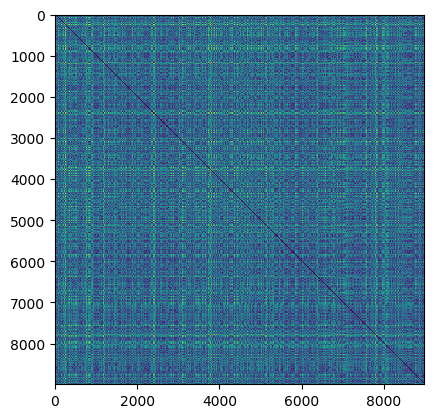

In [49]:
#K LIN + P LIN SCALE 
import numpy as np
import matplotlib.pyplot as plt
p_vals = np.linspace(0.001, 1, 10)
k_vals = np.linspace(1/nodes.shape[0], 300/nodes.shape[0], 10)
cell_locs = nodes
dist = euclidean_distances(nodes)
plt.imshow(dist)
plt.show()

In [ ]:
savepath = F10t + 'Project/' + experiment + os.sep 
repeats = 20
#k and p
#===================================
from scipy import sparse
import scipy
for i in range(len(k_vals)):
    for e in range(len(p_vals)):            
        #output = adfn.parallel_class(4, savepath, adfn.repeat_list(k_vals[i], repeats), netfn.netsim(dist).ws_generate, [p_vals[e], 'directed'], 'NA', ['A'], 'NA')
        #sparse_A = sparse.csr_matrix(output.A)
        #scipy.sparse.save_npz(savepath + 'smallsweep-klin-plin-network-k' + str(k_vals[i]) + '-p' + str(p_vals[e]) + '-' + str(e+1), sparse_A)
        output = adfn.parallel_class(4, savepath, adfn.repeat_list(k_vals[i], repeats), netfn.netsim(dist).cycles, [p_vals[e], 'directed'], 'NA', ['cycles', 'edges'], 'NA')
        np.save(savepath + 'smallsweep2-klin-plin-network-k-' +  str(k_vals[i]) + '-p' + str(p_vals[e]) +  '-cycles.npy', output)
        print('Done network ' + str(i) + ' of ' + str(len(k_vals)))
        

In [50]:
shape = (len(k_vals)*len(p_vals))
count=0
var_vec = np.zeros((shape))
diff_vec = np.zeros((shape))
perc_vec = np.zeros((shape))
for i in range(len(p_vals)):
    curr_list = sorted(glob.glob('*smallsweep2*' + str(k_vals[i]) + '*'))
    for t in range(len(curr_list)):
        edges = np.load(curr_list[t])[1][0] 
        cycs = np.load(curr_list[t])[0]
        var = np.var(cycs)
        diff = np.max(cycs) - np.min(cycs)
        perc = (diff/edges) * 100
        var_vec[count] = var
        diff_vec[count] = diff
        perc_vec[count] = perc
        count+=1
    

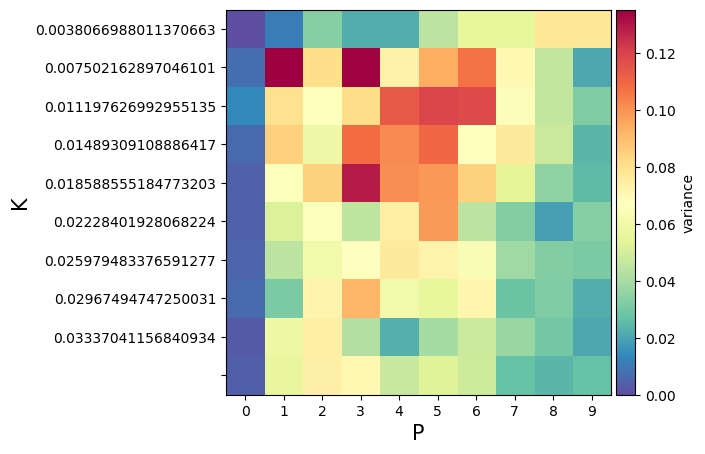

In [51]:
#PERCENTAGE
from mpl_toolkits.axes_grid1 import make_axes_locatable
#divnorm = colors.DivergingNorm(vmin=np.min(mratio), vcenter=150000, vmax=np.max(mratio))
f, ax = plt.subplots(figsize = (8,5))
input_vec = perc_vec
mat = input_vec.reshape((len(k_vals),len(p_vals)))    
plot1 = ax.imshow(mat, cmap = 'Spectral_r')
ax.set_xlabel('P', size = '15')
ax.set_ylabel('K', size = '15')
ax.locator_params(axis='y', nbins=10)
ax.locator_params(axis='x', nbins=10)
#ax.set_xticklabels(p_vals, fontsize = 10)
ax.set_yticklabels(k_vals, fontsize = 10)
divider = make_axes_locatable(ax)
cax0 = divider.append_axes("right", size="5%", pad=0.05)
cbar0 = f.colorbar(plot1, cax=cax0, label = 'variance')
plt.show()

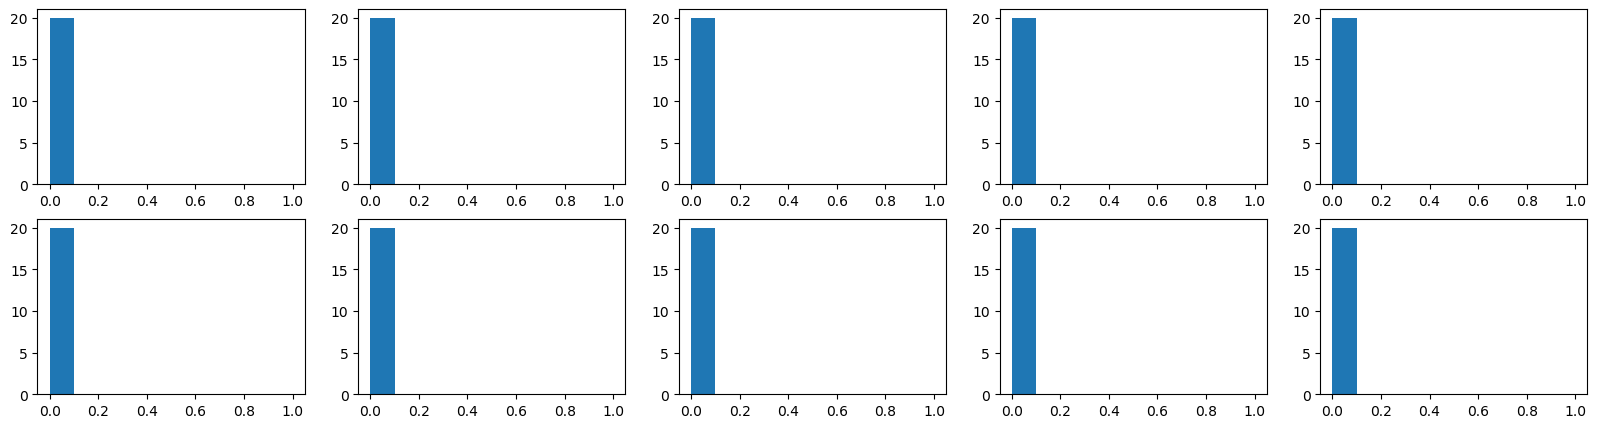

In [109]:
count=0
for i in range(1):#len(p_vals)):
    curr_list = sorted(glob.glob('*smallsweep2*' + str(k_vals[i]) + '*'))
    fig, axarr = plt.subplots(2,5, figsize = (20,5))
    x,y = 0,0
    for t in range(len(curr_list)):  
        prac = np.load(curr_list[t])[0]/np.load(curr_list[t])[1]
        axarr[x][y].hist(prac, bins = 10, range = (0,1))
        y+=1
        if t == 4:
            x = 1
            y = 0
    plt.show()

In [ ]:
#CHECK IF CYCLES MAKE A DIFFERENCE TO SLOPE 
savepath = F10t + 'Project/' + experiment + os.sep 
repeats = 40

#k and p
#===================================
from scipy import sparse
import scipy

output_1 = adfn.parallel_class(4, savepath, adfn.repeat_list(k, repeats), netfn.netsim(dist).cycles, [p, 'directed'], 'NA', ['cycles', 'edges', 'A'], 'NA')

In [ ]:
#ORDER BY CYCLE NUMBER
data = output_1
data_s = sorted(data[0])
new_matlist = list(range(len(data[1])))
for i in range(len(data[0])):
    new_matlist[i] = data[2][np.where(np.asarray(data[0]) == data_s[i])[0][0]]

# Parameter sweep
* start coarse and get finer
* if smooth - gradient descent


In [10]:
savepath = F10t + 'Project/' + experiment + os.sep 

#Network parameters (k,p)
#=====================
n_samp = 10 #samples to choose median cycle network from 
mode = 'directed'
for i in range(len(k_vals)):
    print('k = ' + str(nodes.shape[0]*k_vals[i]) + ' p = ' + str(p_vals[i]))

k = 1.0 p = 0.001
k = 20.0 p = 0.1
k = 37.99999999999999 p = 0.19
k = 56.0 p = 0.28
k = 74.0 p = 0.37
k = 92.0 p = 0.45999999999999996
k = 110.0 p = 0.5499999999999999
k = 128.0 p = 0.64
k = 146.0 p = 0.73
k = 164.0 p = 0.82
k = 182.0 p = 0.9099999999999999
k = 200.0 p = 1.0


In [11]:
#S parameters
#====================
divisor = 200
soften = 0.07

for i in range(len(s_vals)):
    print(' s = ' + str(s_vals[i]))

 s = 0.0
 s = 0.36363636363636365
 s = 0.7272727272727273
 s = 1.0909090909090908
 s = 1.4545454545454546
 s = 1.8181818181818183
 s = 2.1818181818181817
 s = 2.5454545454545454
 s = 2.909090909090909
 s = 3.272727272727273
 s = 3.6363636363636367
 s = 4.0


In [12]:
#Calculate number of simulatons to do - to have 95% chance of generating maximum avalanche
def num_sims(empirical, cutoff):
    import matplotlib.pyplot as plt
    import math
    fig, axarr = plt.subplots(figsize = (7,5))
    hist = axarr.hist(empirical, bins = 100000, density = True, histtype = 'step', cumulative = -1)
    p = 1-(10**(np.log10(hist[0])[np.where(np.log10(hist[1]) > np.log10(cutoff))[0][0]])) #probability of getting avalanches of size cutoff or smaller
    number = 0.05 
    base = p
    exponent = int(math.log(number, base)) #number of simulations as the power to which p is raised to get 95% probability 
    return(exponent)

#Simulation parameters
#======================
cutoff = 1000
n_sims= num_sims(bln_vec, cutoff)
n_sims

36781

In [ ]:
savepath = F10t + 'Project/' + experiment + os.sep 
#Paramater ranges for naming
kmin = k_vals[0]*nodes.shape[0]
kmax = k_vals[len(k_vals)-1]*nodes.shape[0]
kbins = len(k_vals)
pmin = p_vals[0]
pmax = p_vals[len(p_vals)-1]
pbins = len(p_vals)
smin = s_vals[0]
smax = s_vals[len(s_vals)-1]
sbins = len(s_vals)
variables = ['sim_A', 'adj_mat', 'av_size', 'av_dur']

for i in range(len(k_vals)):
    for y in range(len(p_vals)):
        name = 'net-paramsweep_k' + str(kmin) + '-' + str(kmax) + '-'  + str(kbins) + 'bin' + '_p' +  str(pmin) + '-' + str(pmax) + '-' + str(pbins) + 'bin'  '_s' +  str(smin) + '-' + str(smax) + '-' + str(sbins) + 'bin_'+ 'k-' + str(k_vals[i]*nodes.shape[0]) + '-p-' + str(p_vals[y]) + '-s' 
        output = adfn.parallel_class(4, savepath, s_vals, 
                            netfn.netsim(dist).simulate, 
                            [k_vals[i], p_vals[y], 10, divisor, soften, cutoff, n_sims, 'directed'],
                            name, 
                            variables, 
                            'save_single')
    print('Done k ' + str(i) + ' of ' + str(len(k_vals)))

In [15]:
ws_mat = netfn.ws_netsim(dist).adjmat_generate(3, k_vals[3], p_vals[2], 1, divisor, soften, 'directed').A

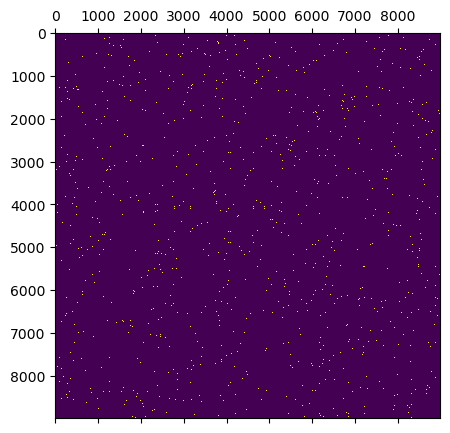

In [17]:
fig, axarr = plt.subplots(figsize = (5,5))                   
axarr.matshow(ws_mat)
plt.show()

In [31]:
n = 100
m = 10
p = 1
ba_G = nx.barabasi_albert_graph(n, m)
ba_mat = nx.to_numpy_array(ba_G)

In [ ]:
pcg_G = nx.powerlaw_cluster_graph(n, m, p )
pcg_mat = nx.to_numpy_array(pcg_G)

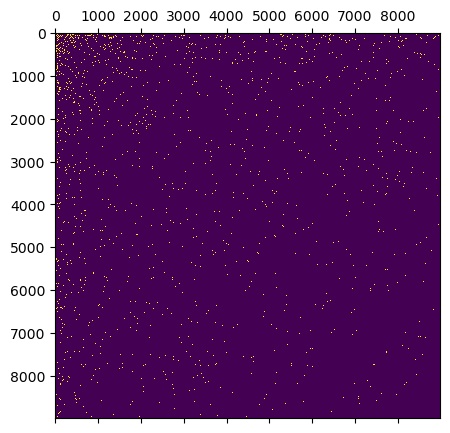

In [19]:
fig, axarr = plt.subplots(figsize = (5,5))                   
axarr.matshow(ba_mat)
plt.show()

In [449]:
def barabasi_albert_graph(n, m, seed=None):
    """Return random graph using Barabási-Albert preferential attachment model.

    A graph of n nodes is grown by attaching new nodes each with m
    edges that are preferentially attached to existing nodes with high
    degree.

    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : int, optional
        Seed for random number generator (default=None).

    Returns
    -------
    G : Graph

    Notes
    -----
    The initialization is a graph with with m nodes and no edges.

    References
    ----------
    .. [1] A. L. Barabási and R. Albert "Emergence of scaling in
       random networks", Science 286, pp 509-512, 1999.
    """

    if m < 1 or  m >=n:
        raise nx.NetworkXError(\
              "Barabási-Albert network must have m>=1 and m<n, m=%d,n=%d"%(m,n))
    if seed is not None:
        random.seed(seed)

    # Add m initial nodes (m0 in barabasi-speak)
    G=empty_graph(m)
    G.name="barabasi_albert_graph(%s,%s)"%(n,m)
    
    # Target nodes for new edges
    targets=list(range(m))
    
    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes=[]
    
    # Start adding the other n-m nodes. The first node is m.
    source=m
    while source<n:
        
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source]*m,targets))
        
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source]*m)
        
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachement)
        targets = _random_subset(repeated_nodes,m)
        
        source += 1
    return G

In [52]:
source = m #source is all nodes currently in network

In [ ]:
targets=list(range(m)) #targets is list of length nodes to connect
targets

In [ ]:
repeated_nodes=[]

In [32]:
n,m

(100, 10)

In [25]:
G=nx.empty_graph(m)
G

In [ ]:
#Add edges to m nodes from the source.
G.add_edges_from(zip([source]*m,targets))

In [37]:
[source]*m

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]

In [38]:
targets

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [54]:
prac = zip([source]*m,targets)
ok = set(prac)
ok

{(10, 0),
 (10, 1),
 (10, 2),
 (10, 3),
 (10, 4),
 (10, 5),
 (10, 6),
 (10, 7),
 (10, 8),
 (10, 9)}

In [79]:
# Add one node to the list for each new edge just created.
repeated_nodes.extend(targets)
repeated_nodes

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 10]

In [80]:
# And the new node "source" has m edges to add to the list.
repeated_nodes.extend([source]*m)
repeated_nodes

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11]

In [84]:
# Now choose m unique nodes from the existing nodes
# Pick uniformly from repeated_nodes (preferential attachement)
targets = _random_subset(repeated_nodes,m)
targets

{0, 1, 2, 3, 4, 5, 6, 7, 10, 11}

In [76]:
targets

{0, 1, 2, 3, 4, 5, 6, 7, 8, 10}

In [85]:
source+=1

In [86]:
prac = zip([source]*m,targets)
ok = set(prac)
ok

{(12, 0),
 (12, 1),
 (12, 2),
 (12, 3),
 (12, 4),
 (12, 5),
 (12, 6),
 (12, 7),
 (12, 10),
 (12, 11)}

In [ ]:
def barabasi_albert_graph(n, m, seed=None):
    """Return random graph using Barabási-Albert preferential attachment model.

    A graph of n nodes is grown by attaching new nodes each with m
    edges that are preferentially attached to existing nodes with high
    degree.

    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : int, optional
        Seed for random number generator (default=None).

    Returns
    -------
    G : Graph

    Notes
    -----
    The initialization is a graph with with m nodes and no edges.

    References
    ----------
    .. [1] A. L. Barabási and R. Albert "Emergence of scaling in
       random networks", Science 286, pp 509-512, 1999.
    """

    if m < 1 or  m >=n:
        raise nx.NetworkXError(\
              "Barabási-Albert network must have m>=1 and m<n, m=%d,n=%d"%(m,n))

    # Add m initial nodes (m0 in barabasi-speak)
    G=empty_graph(m)
    G.name="barabasi_albert_graph(%s,%s)"%(n,m)
    
    # Target nodes for new edges
    targets=list(range(m))
    
    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes=[]
    
    # Start adding the other n-m nodes. The first node is m.
    source=m
    while source<n:
        
        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source]*m,targets))
        
        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source]*m)
        
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachement)
        targets = _random_subset(repeated_nodes,m)
        
        source += 1
    return G

In [100]:
import numpy as np
import networkx as nx
import random
import copy

#n = dist.shape[0] #final number of nodes
n = 100
A = np.zeros((n,n)) #(dist.shape) #initialise graph
k = 5 #number of edges

#c = clustering coefficient
current_n = k #current number of nodes


In [105]:
# Nodes to connect to from current node
nodes_out =list(range(k))
nodes_out

[0, 1, 2, 3, 4]

In [101]:
current_n

5

In [106]:
# Sequence of all nodes connected (in and out) - can sample from this 
node_counts=[]
node_counts

[]

In [108]:
[current_n]*k

[5, 5, 5, 5, 5]

In [ ]:



def sample(seq,m):
    """ Return m unique elements from seq.
    """
    #make targets a set - only contains unique elements
    targets=set()
    while len(targets)<m:
        x=random.choice(seq)
        targets.add(x) #add method only adds if x is not already in target set
    return targets


#iterate until number of nodes = n
while current_n < n:
    A[current_n, nodes_out] = 1
    A[nodes_out, current_n] = 1 
    
    #list of incoming connections for current node - i.e. repeated sequence of current node
    nodes_in = [current_n]*k
    
    #add current nodes receiving outgoing connections to node sequence
    node_counts.extend(nodes_out)
    
    #add current node (as many times as it sends out connections - assumes undirected network) to node sequence
    node_counts.extend(nodes_in)
    
    #update nodes_out - uniformly sample from sequence of node_counts
    nodes_out = sample(repeated_nodes, k)
    
    current_n +=1

In [22]:
#Add each node

for e in range(n - k):
    curr_nodes = copy.deepcopy(A[:current_n]) #matrix of previous nodes up to this point
    new_node_index = current_n  #index of node to add

    prev_nodes = [] #list of all previously selected nodes
    
    #Add each edge iteratively
    for i in range(k):
        new_edge_index = degree_sample(A, curr_nodes, prev_nodes) #Find where to connect to

        A[new_node_index, new_edge_index] = 1
        A[ new_edge_index, new_node_index] = 1
        
        curr_nodes[new_edge_index] = 0 #set newly connected node edges to 0, to avoid double sampling
        prev_nodes = np.append(prev_nodes, new_edge_index)  
    current_n +=1
    
np.sum(A)

950.0

In [21]:
#Returns index of node to connect to
def degree_sample(A, curr_nodes, prev_nodes):
    
    from scipy import stats
    
    #Find degree of all previous nodes
    degree = np.sum(curr_nodes, axis = 1)
    
    #if no edges in network - i.e. first time step
    #==============================================
    if np.sum(A) == 0:
        #randomly pick from all
        return(int(np.random.choice(len(curr_nodes), 1)[0]))
        
    #if degree is 0 and previous nodes have been connected
    #then all nodes with degrees are already connected to current node
    #==================================================================
    if sum(degree) == 0 and len(prev_nodes) > 0:
        #randomly pick from remaining by indexing 
        draw_list = []
        #Eliminate nodes already connected - create new list to draw from
        for i in range(len(curr_nodes)):
            if i not in prev_nodes:
                draw_list = np.append(draw_list, i)

        return(int(random.choice(draw_list)))
    
    #if there are unconnected nodes with degree > 0 - sample from discrete dist
    #==========================================================================
    if sum(degree) > 0:
        #Probabilities for each node
        p = degree/sum(degree)
        #Draw from discrete distribution
        x = np.arange(len(p))
        draw = stats.rv_discrete(values=(x, p))
        return(int(draw.rvs(size=1)[0]))
    


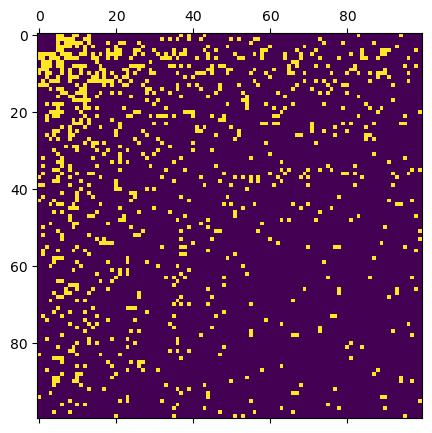

In [23]:
fig, axarr = plt.subplots(figsize = (5,5))                   
axarr.matshow(A)
plt.show()

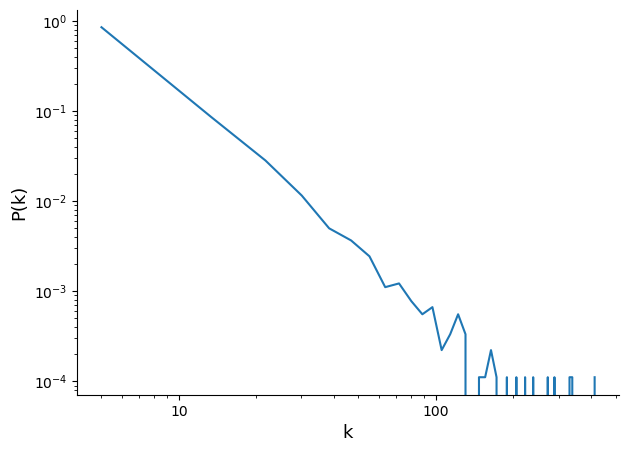

In [446]:
#Degree distribution
import matplotlib 

fig, axarr = plt.subplots(figsize = (7,5))
avdistcut = np.sum(A, axis = 1)
hist = np.histogram(avdistcut, bins = 50)
xaxis = hist[1]
yaxis = hist[0]/np.sum(hist[0])
axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', linewidth = 1.5, markersize = 1, alpha = 1)
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(k)', size = '13')
axarr.set_xlabel('k', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()


In [443]:
n = nodes.shape[0]
m = 5
ba_G = nx.barabasi_albert_graph(n, m)
ba_mat = nx.to_numpy_array(ba_G)

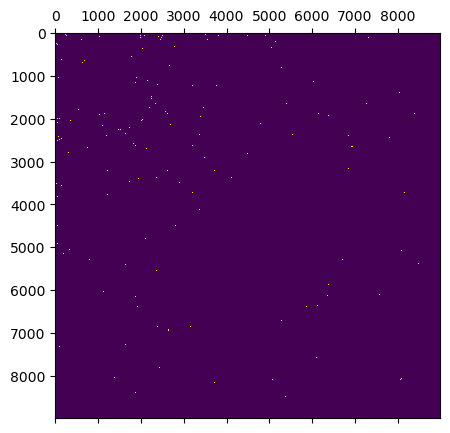

In [444]:
fig, axarr = plt.subplots(figsize = (5,5))                   
axarr.matshow(ba_mat)
plt.show()

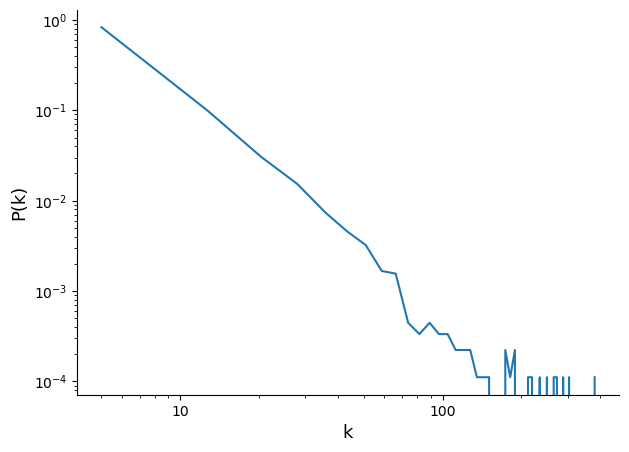

In [445]:
#Degree distribution
import matplotlib 

fig, axarr = plt.subplots(figsize = (7,5))
avdistcut = np.sum(ba_mat, axis = 1)
hist = np.histogram(avdistcut, bins = 50)
xaxis = hist[1]
yaxis = hist[0]/np.sum(hist[0])
axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', linewidth = 1.5, markersize = 1, alpha = 1)
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(k)', size = '13')
axarr.set_xlabel('k', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()


In [22]:
#=====================
#=====================
class ba_netsim: 
#=====================
#=====================
    """
    Class to build barabasi-albert networks
    dist = distance matrix between all nodes in network
    """

    #========================
    def __init__(self,dist):
    #========================
        import numpy as np
        self.dist = dist
    

    #BUILD NETWORK
    #=================
    #=================
    #=====================================
    def net_generate(self, edge_density, p, mode):
    #=====================================
        """
        Generate Barabasi-Albert preferential attachment network. BA model starts with m initial nodes
        
            edge_density = number of k_nearest neighbours each node is connected to
            p = probability of an edge being randomly re-assigned
            mode = directed or undirected
            
        """
        
        #PARAMS - NUMBER OF NODES, NUMBER OF EDGES
        
        #STEP 1:
        # INITIALISE - HOW MANY NODES, HOW MANY CONNECTIONS BETWEEN NODES
        
        
        #STEP2:
        # DEFINE PROBABILITIES
        # ITERATE - EACH STEP ADD NEW NODE, CONNECT TO THE N HIGHEST NODES?
        
        
        #STEP 3:
        #STOP
        
        import numpy as np
        import networkx as nx
        import random
        import copy
        
        if mode!= 'directed' and mode!= 'undirected': 
            print('Select directed or undirected')
            exit()
        self.A = np.zeros(self.dist.shape)
        self.k_neighbours(edge_density, mode)

        # Rewire connections with certain probability
        #-----------------------------------------------------------------------------
        
        if mode == 'undirected':
            [rows, cols]    = np.where(np.triu(self.A) == 1) 
            probs           = np.random.uniform(size = rows.shape[0]) #Generate random values for each connection 
            edges_to_change = np.where(probs <= p)[0] #see which values are randomly changed
            
            for e in range(edges_to_change.shape[0]): #Loop through edges to change
                this_edge = edges_to_change[e]
                self.A[rows[this_edge], cols[this_edge]] = 0         # switch off old edge
                self.A[cols[this_edge], rows[this_edge]] = 0

                where_0 = np.where(self.A[rows[this_edge]] == 0)[0] #find possible connections to reassign to
                new_edge = random.choice(where_0[np.where(where_0 !=rows[this_edge])[0]]) #randomly choose one - ignoring any connections on the diagonal 
                #Assign connection
                self.A[rows[this_edge], new_edge] = 1        # switch on new edge
                self.A[new_edge, rows[this_edge]] = 1
        
        if mode == 'directed':
            [rows, cols]    = np.where(self.A == 1) 
            probs           = np.random.uniform(size = rows.shape[0]) #Generate random values for each connection 
            edges_to_change = np.where(probs <= p)[0] #see which values are randomly changed
        
            # Rewire connections with certain probability
            #-----------------------------------------------------------------------------
            [rows, cols]    = np.where(self.A == 1) 
            probs           = np.random.uniform(size = rows.shape[0]) #Generate random values for each connection 
            edges_to_change = np.where(probs <= p)[0] #see which values are randomly changed

            for e in range(edges_to_change.shape[0]): #Loop through edges to change
                this_edge = edges_to_change[e]
                self.A[rows[this_edge], cols[this_edge]] = 0         # switch off old edge

                where_0 = np.where(self.A[rows[this_edge]] == 0)[0] #find possible connections to reassign to
                new_edge = random.choice(where_0[np.where(where_0 !=rows[this_edge])[0]]) #randomly choose one - ignoring any connections on the diagonal 
                #Assign connection
                self.A[rows[this_edge], new_edge] = 1        # switch on new edge
        return(self)

    
    #CALCULATE CYCLES
    #=================
    #=================
    #===========================
    def cycles_calculate(self, edge_density, p, mode):
    #===========================
        import networkx as nx
        import numpy as np
        
        cyc_mat = self.net_generate(edge_density, p, mode).A #matrix to calculate cycles
        G = nx.from_numpy_matrix(cyc_mat)
        cyc = nx.algorithms.cycle_basis(G)
        edge =  int(np.sum(cyc_mat))
        self.cycles = len(cyc)
        self.edges = edge
        return(self)
        
    #===========================
    def cycles_median(self, edge_density, p, n_samp, mode):
    #===========================
    #select median cycles number for simulations - ensure you capture non-skewed cycle values
        import networkx as nx
        import numpy as np
        cyc_list = list(range(n_samp)) #list containing cycle densities for each iteration
        cyc_mat_list = list(range(n_samp)) #list containing each generated matrix
        for i in range(n_samp):
            curr_mat = self.net_generate(edge_density, p, mode).A #matrix to calculate cycles
            G = nx.from_numpy_matrix(curr_mat)
            cyc = nx.algorithms.cycle_basis(G)
            edge =  int(np.sum(curr_mat))
            cyc_mat_list[i] = curr_mat
            cyc_list[i] = len(cyc)/edge
        if n_samp % 2 == 0:
            self.sim_A  = cyc_mat_list[min(range(len(cyc_list)), key=lambda x: abs(cyc_list[x]-np.median(cyc_list)))] #matrix to run simulation on

        else:
            self.sim_A  = cyc_mat_list[np.where(cyc_list == np.median(cyc_list))[0][0]] #matrix to run simulation on

        return(self) 
    
    
    #BUILD WEIGHT MATRIX
    #===================
    #===================
    # Simple sigmoid function to 'soften' the exponential
    #===========================
    def sig(self, x):
    #===========================
        import numpy as np
        self.sig_output = 1 / (1+np.exp(-x))
        return(self)
    
    # Conversion from distance to edge weights, scaled (itself exponentially) by s
    #====================================
    def dist2edge(self, distance, divisor, soften, s):
    #===================================
        import numpy as np
        self.edge_weight_out = np.exp(s/5)*self.sig(np.exp(-soften/np.exp(s)*distance)).sig_output/divisor
        return(self)  
    
    #===========================
    def adjmat_generate(self, s, edge_density, p, n_samp, divisor, soften, mode):
    #===========================
        import numpy as np
        import copy
        mat = np.zeros((self.dist.shape))
        
        curr_mat = self.cycles_median(edge_density, p, n_samp, mode).sim_A
        
        [rows, cols]    = np.where(np.triu(curr_mat) == 1) 
        for e in range(len(rows)):
            edge_weight = self.dist2edge(self.dist[rows[e], cols[e]], divisor, soften, s).edge_weight_out
            mat[rows[e], cols[e]] = edge_weight 
            mat[cols[e], rows[e]] = edge_weight
        self.adj_mat = copy.deepcopy(mat)
            
        return(self)
    
    
    
    #SIMULATE AVALANCHES
    #===================
    #===================
    
    #Find cells to propagate
    #=====================================================
    def propagate_neighbours(self, curr_mat, start_node):
    #=====================================================
        import numpy as np
        self.prop_nodes = []
        nodes = np.where(curr_mat[start_node] > 0) [0]
        weights = curr_mat[start_node][nodes]
        for f in range(len(nodes)):
            if weights[f] > np.random.uniform(0, 1):
                self.prop_nodes = np.append(self.prop_nodes, nodes[f])
        return(self)

    
    #Simulate 
    #===========================
    def simulate(self,  s, edge_density, p, n_samp, divisor, soften, cutoff, n_sims, mode):
    #===========================
        import numpy as np
        curr_mat = self.adjmat_generate(s, edge_density, p, n_samp, divisor, soften, mode).adj_mat

        self.av_size = []
        self.av_dur = []

        for i in range(n_sims):
            #Decide start node
            start_node = np.random.uniform(0, curr_mat.shape[0]-1)
            down = int(start_node)
            up= int(start_node)+1
            if np.random.uniform(down, up) >= start_node:
                start_node = up
            else:
                start_node = down


            #Initialise avalanche - ping first node
            t_nodes = self.propagate_neighbours(curr_mat, start_node).prop_nodes #Find connected neighbours > threshold
            curr_list = t_nodes
            iterate = 'yes'

            if len(t_nodes) > 1: #must have at least 3 cells to begin avalanche
                all_nodes = np.append(start_node, t_nodes)
                timesteps = 1

                while iterate == 'yes':
                    tplus_nodes = []
                    for z in range(len(curr_list)):
                        #List of all nodes active in next timestep
                        tplus_nodes = np.append(tplus_nodes, self.propagate_neighbours(curr_mat, int(curr_list[z])).prop_nodes)

                    all_nodes = np.append(all_nodes, tplus_nodes)
                    timesteps+=1
                    curr_list = tplus_nodes

                    if len(all_nodes) > cutoff:
                        iterate = 'no'

                    if len(tplus_nodes) == 0: #if no more active cells - stop
                        iterate = 'no'


                self.av_size = np.append(self.av_size, len(all_nodes)) 
                self.av_dur = np.append(self.av_dur, timesteps)

            else:
                continue

        return(self)
    

In [ ]:
#Add recurrent excitation - make recurrent excitation higher for hub nodes?

r_e = 0.2

#Find cells to propagate
#=====================================================
def propagate_neighbours(curr_mat, start_node):
#=====================================================
    import numpy as np
    prop_nodes = []
    nodes = np.where(curr_mat[start_node] > 0) [0]
    weights = curr_mat[start_node][nodes]
    for f in range(len(nodes)):
        if weights[f] > np.random.uniform(0, 1):
            prop_nodes = np.append(prop_nodes, nodes[f])
            
    if r_e > np.random.uniform(0, 1):
        prop_nodes = np.append(prop_nodes, start_node)
    return(prop_nodes)



av_size_1 = []
av_dur_1 = []

for i in range(n_sims):
    
    #Decide start node
    start_node = np.random.uniform(0, curr_mat.shape[0]-1)
    down = int(start_node)
    up= int(start_node)+1
    if np.random.uniform(down, up) >= start_node:
        start_node = up
    else:
        start_node = down

    #Initialise avalanche - ping first node
    t_nodes = propagate_neighbours(curr_mat, start_node) #Find connected neighbours > threshold
    curr_list = t_nodes
    iterate = 'yes'


    if len(t_nodes) > 1: #must have at least 3 cells to begin avalanche
        all_nodes = np.append(start_node, t_nodes)
        timesteps = 1

        while iterate == 'yes':
            tplus_nodes = []
            for z in range(len(curr_list)):
                
                #List of all nodes active in next timestep
                tplus_nodes = np.append(tplus_nodes, propagate_neighbours(curr_mat, int(curr_list[z])))
                                

            all_nodes = np.append(all_nodes, tplus_nodes)
            timesteps+=1
            curr_list = tplus_nodes

            if len(all_nodes) > cutoff:
                iterate = 'no'

            if len(tplus_nodes) == 0: #if no more active cells - stop
                iterate = 'no'


        av_size_1 = np.append(av_size_1, len(all_nodes)) 
        av_dur_1 = np.append(av_dur_1, timesteps)


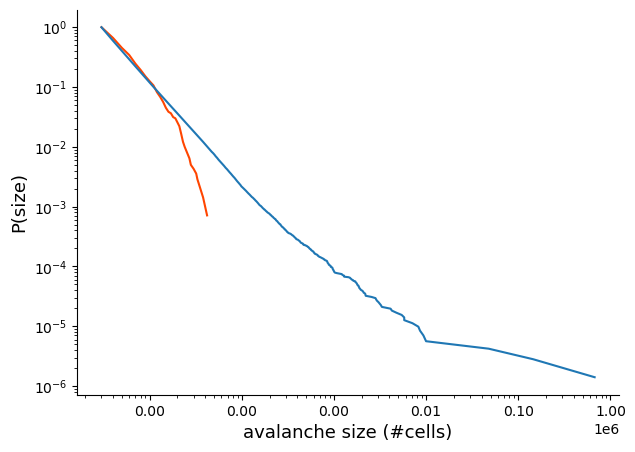

In [215]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy

colors = cm.cool(np.linspace(0, 1, len(node)))

#Cycle length - small network
import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))                   
# Node coordinates
#---------------------------------------------------------------------------
os.chdir(F10t + 'Project/' + experiment)
powerlaw.plot_ccdf(av_size, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = 'orangered')



avdistcut = bln_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1)

        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

# Fit optimal parameter combination
* Gradient descent
* Objective function - Minimise KS distance to empirical distributions

In [65]:
#Check paramaters
print('divisor = ' + str(divisor))
print('soften = ' + str(soften))
print('cutoff = ' + str(cutoff))
print('n_sims = ' + str(n_sims))
s = s_vals[1]
k = k_vals[1]
p = p_vals[1]

divisor = 200
soften = 0.07
cutoff = 1000
n_sims = 36781


In [13]:
#Find minimum value to start with
minlist = []
for i in range(len(kslist_k)-1):
    current = kslist_k[i+1]
    minlist = np.append(minlist, np.min(current))
    
current_k = np.where(minlist == np.min(minlist))[0][0] + 1
matrix_of_min = kslist_k[current_k]
index_of_min = np.where(matrix_of_min == np.min(minlist))
s0 = s_vals[0]
k0 = k_vals[current_k]
p0 = p_vals[0]

print('s0 = ' + str(s_vals[0]))
print('k0 = ' + str(k_vals[current_k]))
print('p0 = ' + str(p_vals[0]))

NameError: name 'kslist_k' is not defined

In [66]:
s0 = 0.0
k0 = 0.01824249165739711
p0 = 0.001
print('s0 = ' + str(s0))
print('k0 = ' + str(k0))
print('p0 = ' + str(p0))

s0 = 0.0
k0 = 0.01824249165739711
p0 = 0.001


In [67]:
s0 = s_vals[11]
k0 = k_vals[11]
p0 = p_vals[11]
print('s0 = ' + str(s0))
print('k0 = ' + str(k0))
print('p0 = ' + str(p0))

s0 = 4.0
k0 = 0.02224694104560623
p0 = 1.0


In [ ]:
from scipy.optimize import minimize

def ks_dist(params):
    print(params)  # <-- you'll see that params is a NumPy array
    s, k, p  = params # <-- for readability you may wish to assign names to the component variables
    avs = netfn.netsim(dist).simulate(s, k, p, 10, divisor, soften, cutoff, n_sims, 'directed').av_size
    ks = stats.ks_2samp(empirical, avs)[0]
    print('ks = ' + str(ks))
    return ks

#Define params
empirical = bln_vec
dist = dist
initial_guess = [s0, k0, p0]
bnds = ( (0,1), (5/nodes.shape[0], 300/nodes.shape[0]),  (0,1) )
result = minimize(ks_dist, initial_guess, bounds = bnds)

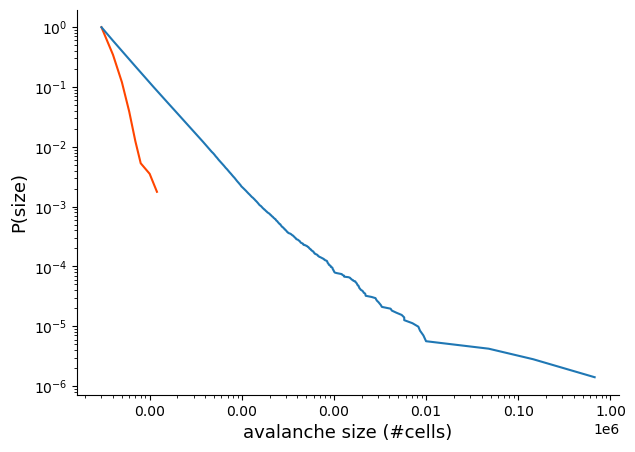

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy

colors = cm.cool(np.linspace(0, 1, len(node)))

#Cycle length - small network
import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   
# Node coordinates
#---------------------------------------------------------------------------
os.chdir(F10t + 'Project/' + experiment)
powerlaw.plot_ccdf(check1, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = 'orangered')

avdistcut = bln_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1)
#avdistcut = p20_vec
#powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1)
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

In [45]:
os.chdir(F10t + 'Project/' + experiment)
min_vec = []
#Network parameters (k,p)
#=====================
kslist_k = list(range(len(k_vals[:10])))
for i in range(len(k_vals[:10])):
    kname = '_k-' + str(nodes.shape[0]*k_vals[i]) 
    kslist = np.zeros((len(p_vals), len(k_vals)))
    for e in range(len(p_vals)):
        pname = '-p-' + str(p_vals[e])
        s_list = sorted(glob.glob('net-paramsweep*' + kname + '*' + pname + '-*' + 'av_size*'))
        for z in range(len(s_list)):
            av_sparse = scipy.sparse.load_npz(s_list[z])
            av_dense = np.array(av_sparse.todense())[0]
            empirical = bln_vec
            
            if len(av_dense) == 0:
                kslist[e,z] = 0
            else:
                kslist[e,z] = stats.ks_2samp(empirical, av_dense)[0]
                min_vec = np.append(min_vec, stats.ks_2samp(empirical, av_dense)[0])
    kslist_k[i] = kslist
    
#Find min value 
for i in range(len(k_vals[:10])):
    kname = '_k-' + str(nodes.shape[0]*k_vals[i]) 
    kslist = np.zeros((len(p_vals), len(k_vals)))
    for e in range(len(p_vals)):
        pname = '-p-' + str(p_vals[e])
        s_list = sorted(glob.glob('net-paramsweep*' + kname + '*' + pname + '-*' + 'av_size*'))
        for z in range(len(s_list)):
            av_sparse = scipy.sparse.load_npz(s_list[z])
            av_dense = np.array(av_sparse.todense())[0]
            empirical = bln_vec
            
            if len(av_dense) == 0:
                continue
            else:
                current = stats.ks_2samp(empirical, av_dense)[0]
                if current == np.min(min_vec):
                    print(s_list[z])
                    print(str(np.min(min_vec)))
                    break
                    
        

net-paramsweep_k1.0-200.0-12bin_p0.001-1.0-12bin_s0.0-4.0-12bin_k-164.0-p-0.001-s-0.0-av_size.npz
0.05323313204922753


<ipython-input-20-c7bfb9668a99>:6: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  divnorm = colors.DivergingNorm(vmin=min(np.ravel(kslist_k[1:])), vcenter=np.median(np.ravel(kslist_k[1:])), vmax=max(np.ravel(kslist_k[1:])))


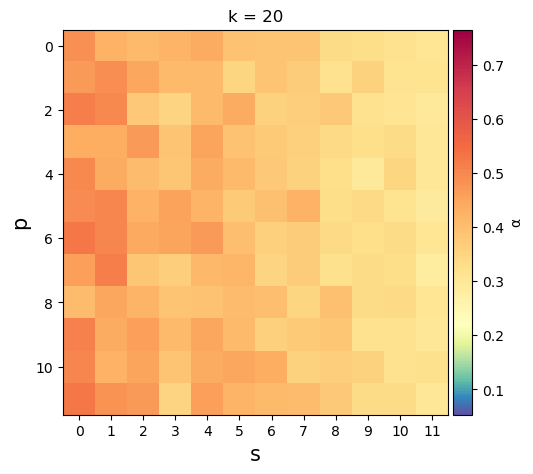

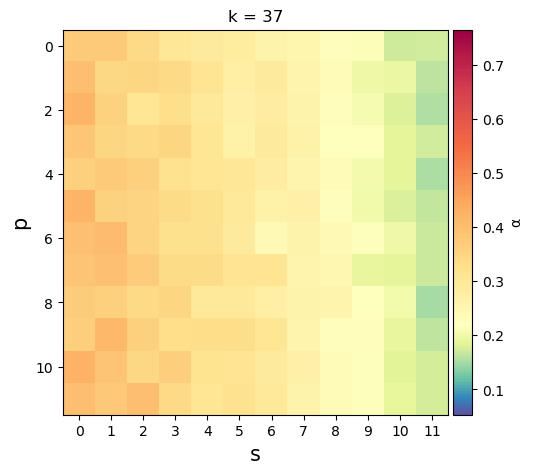

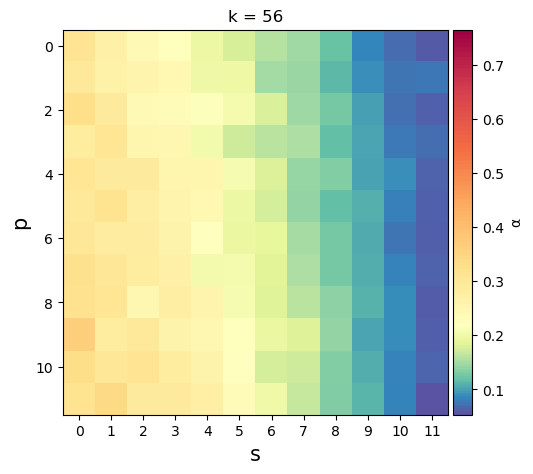

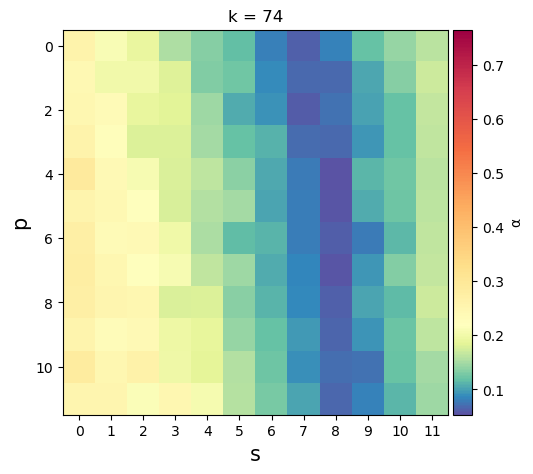

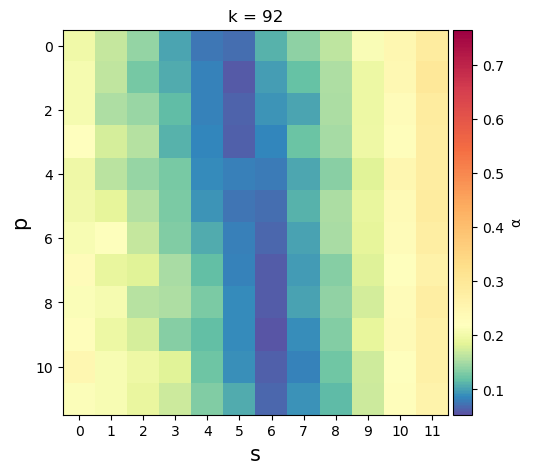

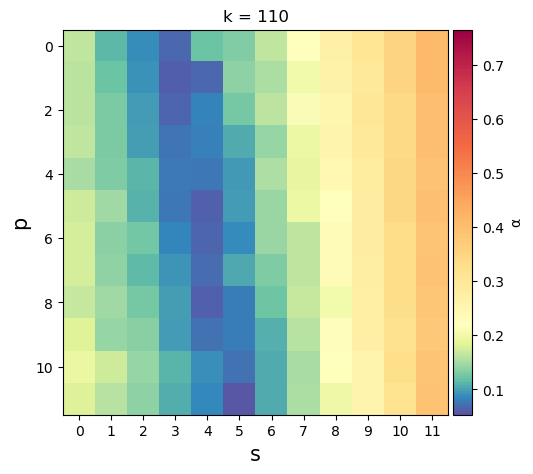

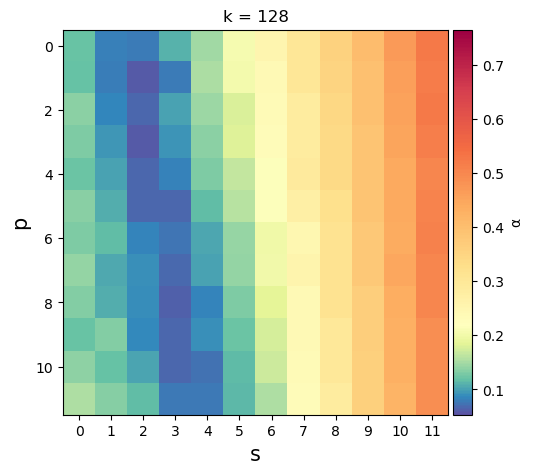

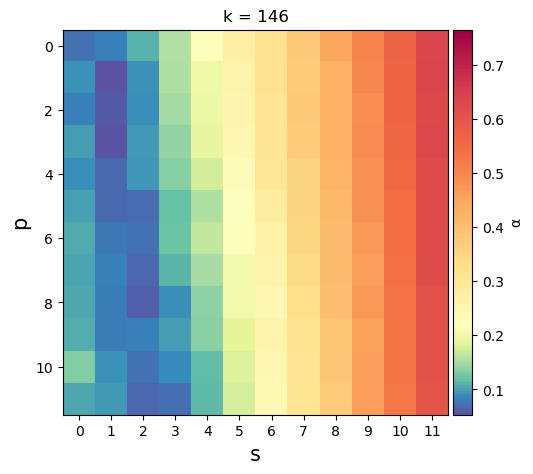

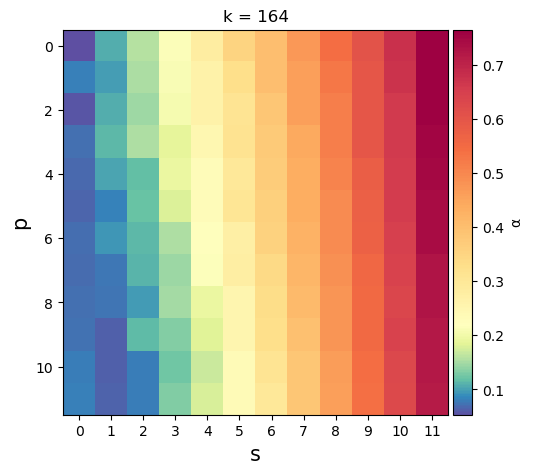

In [20]:
#KS distance
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

minlist = []
divnorm = colors.DivergingNorm(vmin=min(np.ravel(kslist_k[1:])), vcenter=np.median(np.ravel(kslist_k[1:])), vmax=max(np.ravel(kslist_k[1:])))
for i in range(len(kslist_k)-1):
    current = kslist_k[i+1]
    f, ax = plt.subplots(figsize = (8,5))
    plot1 = ax.imshow(current, cmap = 'Spectral_r', norm = divnorm)
    ax.set_title('k = ' + str(int(k_vals[i+1]*nodes.shape[0])))
    ax.set_xlabel('s', size = '15')
    ax.set_ylabel('p', size = '15')
    ax.locator_params(axis='y', nbins=10)
    ax.locator_params(axis='x', nbins=20)
    divider = make_axes_locatable(ax)
    cax0 = divider.append_axes("right", size="5%", pad=0.05)
    cbar0 = f.colorbar(plot1, cax=cax0, label = 'α')
    minlist = np.append(minlist, np.min(current))
    plt.show()

In [47]:
min_plot = scipy.sparse.load_npz('net-paramsweep_k1.0-200.0-12bin_p0.001-1.0-12bin_s0.0-4.0-12bin_k-164.0-p-0.001-s-0.0-av_size.npz')
min_plot

<1x2903 sparse matrix of type '<class 'numpy.float64'>'
	with 2903 stored elements in Compressed Sparse Column format>

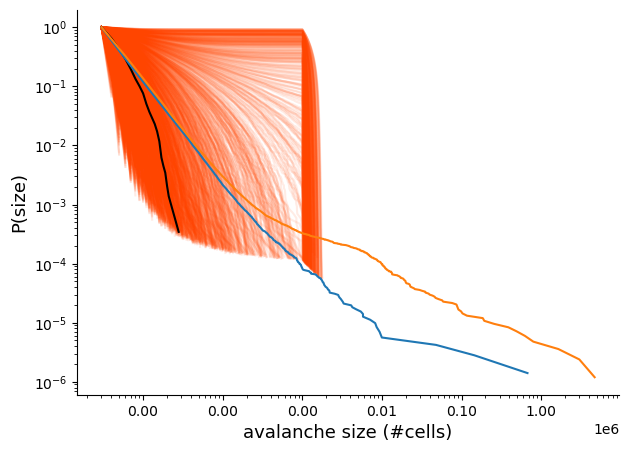

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
import copy     
import scipy

colors = cm.cool(np.linspace(0, 1, len(node)))

#Cycle length - small network
import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   
# Node coordinates
#---------------------------------------------------------------------------
os.chdir(F10t + 'Project/' + experiment)
node = sorted(glob.glob('net-param*av_size*'))[144:]
for i in range(len(node)):
    av_sparse = scipy.sparse.load_npz(node[i])
    av_dense = np.array(av_sparse.todense())[0]
    powerlaw.plot_ccdf(av_dense, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 0.1, c = 'orangered')
    
min_plot = scipy.sparse.load_npz('net-paramsweep_k1.0-200.0-12bin_p0.001-1.0-12bin_s0.0-4.0-12bin_k-164.0-p-0.001-s-0.0-av_size.npz')
av_dense = np.array(min_plot.todense())[0]
powerlaw.plot_ccdf(av_dense, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = 'k')
avdistcut = bln_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1)
avdistcut = p20_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1)
        
axarr.set_xscale('log')
axarr.set_yscale('log')    
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

In [58]:
os.chdir(Fdrop + 'Project/' + experiment)

choose = 0
bln_distlist = [np.load(blnlist[i])[choose] for i in range(len(blnlist))]
p20_distlist = [np.load(p20list[i])[choose] for i in range(len(p20list))]
bln_vec = []
p20_vec = []
for i in range(len(bln_distlist)):
    bln_vec = np.append(bln_vec, bln_distlist[i])
    p20_vec = np.append(p20_vec, p20_distlist[i])
    
cut_bln_vec = bln_vec[np.where(bln_vec < cutoff)]
cut_p20_vec = p20_vec[np.where(p20_vec < cutoff)]

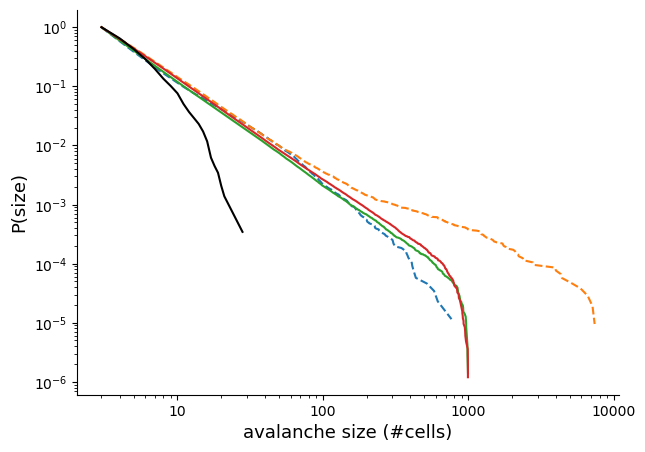

In [82]:
import matplotlib
import powerlaw
fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
cutoff=10000
choose = 3

os.chdir(Fdrop + 'Project/' + experiment)
avdistcut = np.load(blnlist[choose])[0]
avdistcut = avdistcut[np.where(avdistcut < cutoff)]
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =1.5 , markersize = 1, alpha = 1)
avdistcut = np.load(p20list[choose])[0]
avdistcut = avdistcut[np.where(avdistcut < cutoff)]
powerlaw.plot_ccdf(avdistcut, linestyle = '--',linewidth =1.5 , markersize = 1, alpha = 1)

avdistcut = cut_bln_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1)
avdistcut = cut_p20_vec
powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1)

os.chdir(F10t + 'Project/' + experiment)    
min_plot = scipy.sparse.load_npz('net-paramsweep_k1.0-200.0-12bin_p0.001-1.0-12bin_s0.0-4.0-12bin_k-164.0-p-0.001-s-0.0-av_size.npz')
av_dense = np.array(min_plot.todense())[0]
powerlaw.plot_ccdf(av_dense, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = 'k')

axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

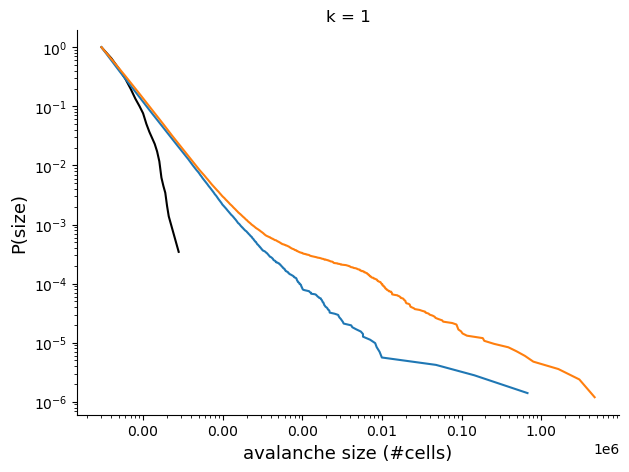

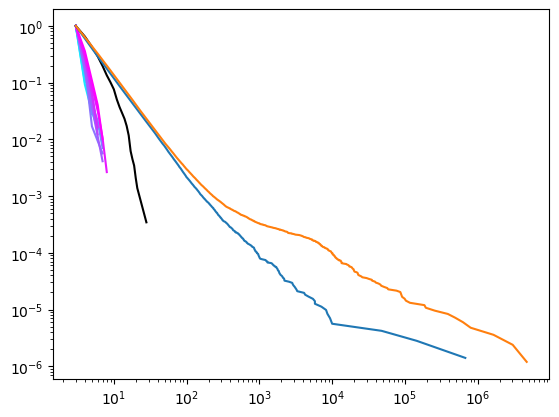

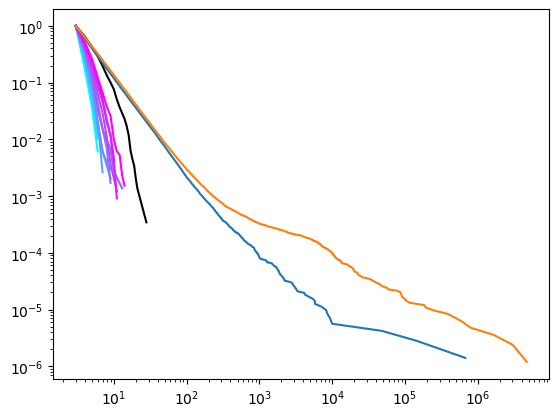

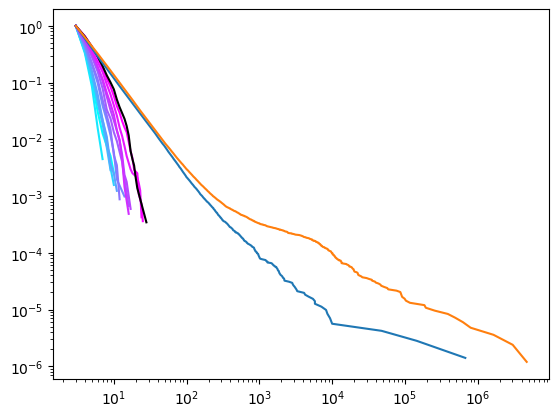

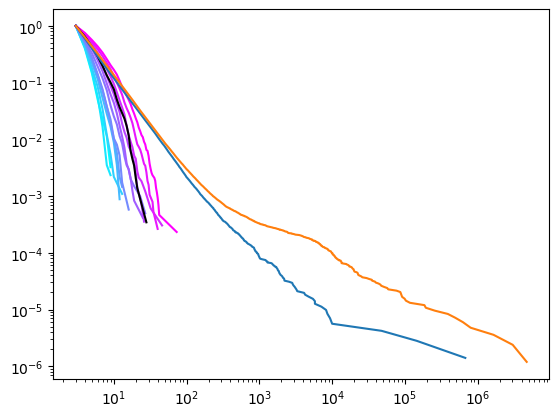

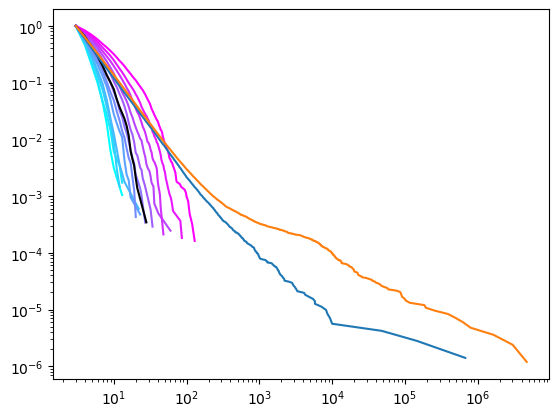

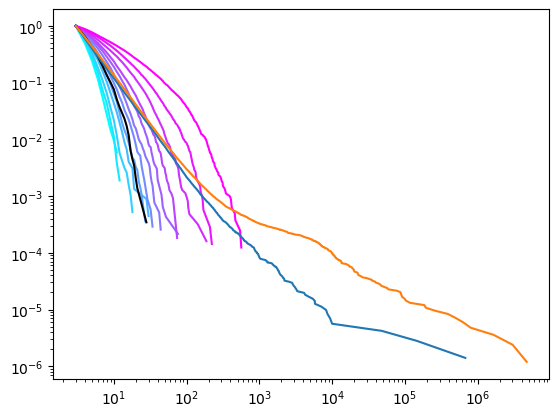

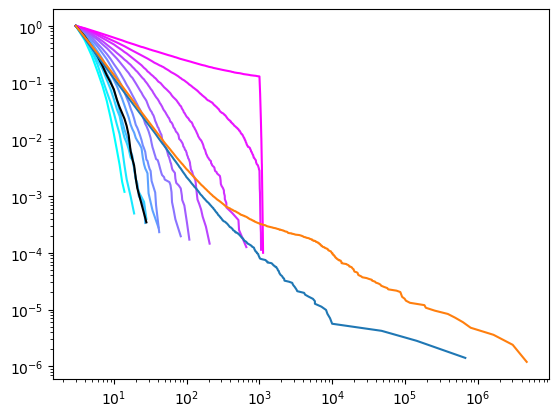

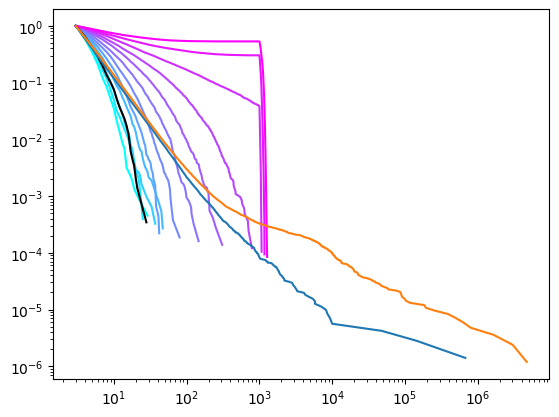

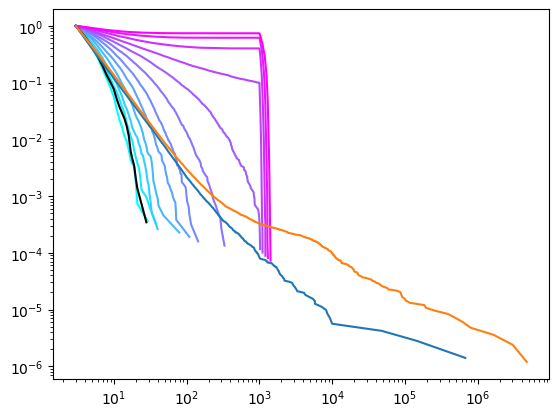

In [49]:
#Cycle length - small network
import matplotlib
import powerlaw

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()
                   
# Node coordinates
#---------------------------------------------------------------------------
os.chdir(F10t + 'Project/' + experiment)    
kslist_k = list(range(len(k_vals[:10])))
for i in range(len(k_vals[:10])):
    kname = '_k-' + str(nodes.shape[0]*k_vals[i]) 
    kslist = np.zeros((len(p_vals), len(k_vals)))
    pname = '-p-' + str(p_vals[5])
    s_list = sorted(glob.glob('net-paramsweep*' + kname + '*' + pname + '-*' + 'av_size*'))
    colors = cm.cool(np.linspace(0, 1, len(s_list)))
    for z in range(len(s_list)):
        av_sparse = scipy.sparse.load_npz(s_list[z])
        av_dense = np.array(av_sparse.todense())[0]
        powerlaw.plot_ccdf(av_dense, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[z])
    min_plot = scipy.sparse.load_npz('net-paramsweep_k1.0-200.0-12bin_p0.001-1.0-12bin_s0.0-4.0-12bin_k-164.0-p-0.001-s-0.0-av_size.npz')
    av_dense = np.array(min_plot.todense())[0]
    powerlaw.plot_ccdf(av_dense, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = 'k')
    avdistcut = bln_vec
    powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1)
    avdistcut = p20_vec
    powerlaw.plot_ccdf(avdistcut, linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1)
    axarr.set_title('k = ' + str(int(k_vals[i]*nodes.shape[0])))
    axarr.set_xscale('log')
    axarr.set_yscale('log')    
    axarr.set_ylabel('P(size)', size = '13')
    axarr.set_xlabel('avalanche size (#cells)', size = '13')
    axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axarr.spines['top'].set_visible(False)
    axarr.spines['right'].set_visible(False)
    plt.show()

# Effect of individual parameters
1. Bayesian approach - which singular parameter change best explains shift during seizures

### Cycles

In [ ]:
#Cycle length - small network
import matplotlib
import powerlaw
colors = cm.cool(np.linspace(0, 1, len(av_size_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_size_list)):
    av = np.append(av, av_size_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_size_list)):
    binned=np.linspace(mini,maxi, 100)
    hist = np.histogram(av_size_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    #axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
    powerlaw.plot_ccdf(av_size_list[i], linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

In [ ]:
#Cycle number
import matplotlib
colors = cm.cool(np.linspace(0, 1, len(av_dur_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_dur_list)):
    av = np.append(av, av_dur_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_dur_list)):
    binned=np.linspace(mini,maxi, 10)
    hist = np.histogram(av_dur_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    #axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
    powerlaw.plot_ccdf(av_dur_list[i], linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

In [ ]:
#Cycle length - high k
import matplotlib
import powerlaw
colors = cm.cool(np.linspace(0, 1, len(av_size_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_size_list)):
    av = np.append(av, av_size_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_size_list)):
    binned=np.linspace(mini,maxi, 100)
    hist = np.histogram(av_size_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    #axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
    powerlaw.plot_ccdf(av_size_list[i], linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

In [ ]:
#Cycle length - high k
import matplotlib
import powerlaw
colors = cm.cool(np.linspace(0, 1, len(av_size_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_size_list)):
    av = np.append(av, av_size_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_size_list)):
    binned=np.linspace(mini,maxi, 100)
    hist = np.histogram(av_size_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    #axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
    powerlaw.plot_ccdf(av_size_list[i], linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

In [ ]:
#Cycle length number
import matplotlib
colors = cm.cool(np.linspace(0, 1, len(av_dur_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_dur_list)):
    av = np.append(av, av_dur_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_dur_list)):
    binned=np.linspace(mini,maxi, 10)
    hist = np.histogram(av_dur_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    #axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
    powerlaw.plot_ccdf(av_dur_list[i], linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

In [ ]:
#Cycle number - 0 edges
import matplotlib
import powerlaw
colors = cm.cool(np.linspace(0, 1, len(av_size_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_size_list)):
    av = np.append(av, av_size_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_size_list)):
    binned=np.linspace(mini,maxi, 10)
    hist = np.histogram(av_size_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    #axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
    powerlaw.plot_ccdf(av_size_list[i], linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

In [ ]:
#Cycle number
import matplotlib
colors = cm.cool(np.linspace(0, 1, len(av_dur_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_dur_list)):
    av = np.append(av, av_dur_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_dur_list)):
    binned=np.linspace(mini,maxi, 10)
    hist = np.histogram(av_dur_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    #axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
    powerlaw.plot_ccdf(av_dur_list[i], linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

### K

In [ ]:
import matplotlib
colors = cm.cool(np.linspace(0, 1, len(av_size_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_size_list)):
    av = np.append(av, av_size_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_size_list)):
    binned=np.linspace(mini,maxi, 40)
    hist = np.histogram(av_size_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

In [ ]:
import matplotlib
colors = cm.cool(np.linspace(0, 1, len(av_dur_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_dur_list)):
    av = np.append(av, av_dur_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_dur_list)):
    binned=np.linspace(mini,maxi, 30)
    hist = np.histogram(av_size_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

### P

In [ ]:
import matplotlib
colors = cm.cool(np.linspace(0, 1, len(av_size_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_size_list)):
    av = np.append(av, av_size_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_size_list)):
    binned=np.linspace(mini,maxi, 40)
    hist = np.histogram(av_size_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    #axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
    powerlaw.plot_ccdf(av_size_list[i], linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

In [ ]:
import matplotlib
colors = cm.cool(np.linspace(0, 1, len(av_dur_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_dur_list)):
    av = np.append(av, av_dur_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_dur_list)):
    binned=np.linspace(mini,maxi, 40)
    hist = np.histogram(av_dur_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    #axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
    powerlaw.plot_ccdf(av_dur_list[i], linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

### S

In [ ]:
import matplotlib
colors = cm.cool(np.linspace(0, 1, len(av_size_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_size_list)):
    av = np.append(av, av_size_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_size_list)):
    binned=np.linspace(mini,maxi, 40)
    hist = np.histogram(av_size_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    #axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
    powerlaw.plot_ccdf(av_size_list[i], linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

In [ ]:
import matplotlib
colors = cm.cool(np.linspace(0, 1, len(av_dur_list)))

fig, axarr = plt.subplots(figsize = (7,5))
sns.reset_orig()

av = []
for i in range(len(av_dur_list)):
    av = np.append(av, av_dur_list[i])
    
mini = np.min(av)
maxi = np.max(av)

for i in range(len(av_dur_list)):
    binned=np.linspace(mini,maxi, 40)
    hist = np.histogram(av_dur_list[i], bins = binned)
    xaxis = hist[1][:-1]
    yaxis = hist[0]/np.sum(hist[0])
    #axarr.plot(xaxis[:len(xaxis)-1], yaxis[:len(xaxis)-1], '-', color = colors[i], linewidth = 1.5, markersize = 1, alpha = 1)
    powerlaw.plot_ccdf(av_dur_list[i], linestyle = '-',linewidth =1.5 , markersize = 1, alpha = 1, c = colors[i])
axarr.set_xscale('log')
axarr.set_yscale('log')
axarr.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axarr.set_ylabel('P(size)', size = '13')
axarr.set_xlabel('avalanche size (#cells)', size = '13')
axarr.spines['top'].set_visible(False)
axarr.spines['right'].set_visible(False)
plt.show()

# Old parameter sweep

In [ ]:
#K + P - LOG SCALE 
import numpy as np
import matplotlib.pyplot as plt
p_vals = np.geomspace(0.001, 1, 50)
p_vals = [round(p_vals[i],4) for i in range(p_vals.shape[0])]
k_vals = np.geomspace((1/nodes.shape[0]), 0.5, 50)
k_vals = [round(k_vals[i], 6) for i in range(k_vals.shape[0])]

cell_locs = nodes
dist = euclidean_distances(nodes)


newp_vals = []
for i in range(len(cyclist)):
    newp_vals = np.append(newp_vals,cyclist[i][cyclist[i].find('-p')+1:cyclist[i].find('-cy')])

In [ ]:
savepath = F10t + 'Project/' + experiment + os.sep 

# Sweep through k and p
#----------------------------------------
from scipy import sparse
import scipy
import networkx as nx
for i in range(len(k_vals)):
    for e in range(len(p_vals)):
        output = netfn.netsim(dist).ws_generate(k_vals[i], p_vals[e])       
        sparse_A = sparse.csr_matrix(output.A)   
    
        scipy.sparse.save_npz(savepath + 'psweep2-netparam-k' + str(k_vals[i]) + '-p' + str(p_vals[e]), sparse_A)
    adfn.timeprint(10, i, len(k_vals), str(k_vals[i]))

In [ ]:
# Calculate cycles
#----------------------------------------
from scipy import sparse
import scipy
import networkx as nx
for i in range(len(p_vals)):
    p_list = sorted(glob.glob('psweep2*p*' + str(p_vals[i]) + '*'))
    cyc_list = adfn.list_of_list(len(p_list),3)
    for e in range(len(p_list)):
        mat = scipy.sparse.load_npz(p_list[e])
        mat = mat.todense()
        G = nx.from_numpy_matrix(mat)
        cyc = nx.algorithms.cycle_basis(G)
        edge =  G.number_of_edges() 
        cyc_vec = np.zeros(len(cyc))
        for t in range(len(cyc)):
            cyc_vec[t] = len(cyc[t])
        cyc_list[e] = [np.unique(cyc_vec, return_counts=True),len(cyc),edge]
    np.save(savepath + 'netparam2-' + p_list[0][p_list[0].find('-p')+1:p_list[0].find('.npz')] + '-cycles.npy', cyc_list)
    print('Done fish ' + str(p_vals[i]))

In [ ]:
#Calculate cycle parameters 
cyc_n_list = list(range(len(cyclist)))
cyc_nodes_list = list(range(len(cyclist)))
mean_cyc_nodes_list = list(range(len(cyclist)))

for i in range(len(cyclist)):
    cyc_n = np.zeros(len(np.load(cyclist[i], allow_pickle=True)))
    cyc_nodes = np.zeros(len(np.load(cyclist[i], allow_pickle=True)))
    mean_cyc_nodes = np.zeros(len(np.load(cyclist[i], allow_pickle=True)))
    for e in range(len(np.load(cyclist[i], allow_pickle=True))):
        cyc_n[e] = np.load(cyclist[i], allow_pickle=True)[e][2]
        multi = np.multiply(np.load(cyclist[i], allow_pickle=True)[e][0][0],np.load(cyclist[i], allow_pickle=True)[e][0][1])
        cyc_nodes[e] =  np.sum(multi)
        mean_cyc_nodes[e] = (cyc_nodes[e]/cyc_n[e])
    cyc_n_list[i] = cyc_n
    cyc_nodes_list[i] = cyc_nodes
    mean_cyc_nodes_list[i] = mean_cyc_nodes
    

In [ ]:
#As k increases how do cycles increase for all p values
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

colors = cm.cool(np.linspace(0, 1, len(cyclist)))
fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(cyc_n_list)):
    plot1 = plt.plot(k_vals, cyc_n_list[i], c = colors[i],label = cyclist[i][cyclist[i].find('-p')+1:cyclist[i].find('-c')])
    axarr.set_title(str('cycle number'))
    axarr.set_ylabel('cycles', size = '13')
    axarr.set_xlabel('k', size = '13')
    axarr.set_xscale('log')
    axarr.set_yscale('log')

#axarr.legend()
plt.show()

In [ ]:
# as k increases how does cycle length increase for each p
colors = cm.cool(np.linspace(0, 1, len(cyclist)))
fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(cyc_nodes_list)):
    plt.plot(k_vals, cyc_nodes_list[i], c = colors[i], label = cyclist[i][cyclist[i].find('-p')+1:cyclist[i].find('-c')])
    axarr.set_title(str('total cycle length'))
    axarr.set_ylabel('total cycle length', size = '13')
    axarr.set_xlabel('k', size = '13')
axarr.set_xscale('log')
axarr.set_yscale('log')
#plt.xlim(right = 0.1)  

#axarr.legend()
plt.show()

In [ ]:
# as k increases how does mean cycle length change for each p

fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(mean_cyc_nodes_list)):
    plt.plot(k_vals, mean_cyc_nodes_list[i], c = colors[i], label = cyclist[i][cyclist[i].find('-p')+1:cyclist[i].find('-c')])
    axarr.set_title(str('mean cycle length'))
    axarr.set_ylabel('mean cycle length', size = '13')
    axarr.set_xlabel('k', size = '13')
axarr.set_xscale('log')
axarr.set_yscale('log')
#axarr.legend()
plt.show()

In [ ]:
#Calculate cycle parameters 
cyc_n_list = list(range(len(np.load(cyclist[0],allow_pickle=True))))
cyc_nodes_list = list(range(len(np.load(cyclist[0],allow_pickle=True))))
mean_cyc_nodes_list = list(range(len(np.load(cyclist[0],allow_pickle=True))))

for i in range(len(np.load(cyclist[0],allow_pickle=True))):     
    cyc_n = np.zeros(len(cyclist))
    cyc_nodes = np.zeros(len(cyclist))
    mean_cyc_nodes = np.zeros(len(cyclist))
    for e in range(len(cyclist)):
        cyc_n[e] = np.load(cyclist[e], allow_pickle=True)[i][2]
        multi = np.multiply(np.load(cyclist[e], allow_pickle=True)[i][0][0],np.load(cyclist[e], allow_pickle=True)[i][0][1])
        cyc_nodes[e] =  np.sum(multi)
        mean_cyc_nodes[e] = (cyc_nodes[e]/cyc_n[e])
    cyc_n_list[i] = cyc_n
    cyc_nodes_list[i] = cyc_nodes
    mean_cyc_nodes_list[i] = mean_cyc_nodes

In [ ]:
newp_vals = []
for i in range(len(cyclist)):
    newp_vals = np.append(newp_vals,cyclist[i][cyclist[i].find('-p')+2:cyclist[i].find('-cy')])

In [ ]:
# as p increases how does cycles increase for each k
colors = cm.cool(np.linspace(0, 1, len(cyc_n_list)))
fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(cyc_n_list)):
    plt.plot(newp_vals.astype(float), cyc_n_list[i], c = colors[i], label = k_vals[i])
    axarr.set_title(str('cycle number'))
    axarr.set_ylabel('cycles', size = '13')
    axarr.set_xlabel('p', size = '13')
axarr.set_xscale('log')
axarr.set_yscale('log')
#axarr.legend()
plt.show()

In [ ]:
#as p increases how does total cycle length increase for each k

fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(cyc_nodes_list)):
    plt.plot(newp_vals.astype(float), cyc_nodes_list[i], c = colors[i], label = k_vals[i])
    axarr.set_title(str('total cycle length'))
    axarr.set_ylabel('total cycle length', size = '13')
    axarr.set_xlabel('p', size = '13')
#axarr.set_xscale('log')
#axarr.set_yscale('log')
#axarr.legend()
plt.show()

In [ ]:
# as p increases how does mean cycle length increase
fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(mean_cyc_nodes_list)):
    plt.plot(newp_vals.astype(float), mean_cyc_nodes_list[i], c = colors[i], label = k_vals[i])
    axarr.set_title(str('mean cycle length'))
    axarr.set_ylabel('mean cycle length', size = '13')
    axarr.set_xlabel('p', size = '13')
#axarr.set_xscale('log')
#axarr.set_yscale('log')
#axarr.legend()
plt.show()

In [ ]:
#K + P - LIN SCALE (low p)
#Calculate cycle parameters 
cyc_n_list = list(range(len(cyclist)))
cyc_nodes_list = list(range(len(cyclist)))
mean_cyc_nodes_list = list(range(len(cyclist)))

for i in range(len(cyclist)):
    cyc_n = np.zeros(len(np.load(cyclist[i], allow_pickle=True)))
    cyc_nodes = np.zeros(len(np.load(cyclist[i], allow_pickle=True)))
    mean_cyc_nodes = np.zeros(len(np.load(cyclist[i], allow_pickle=True)))
    for e in range(len(np.load(cyclist[i], allow_pickle=True))):
        cyc_n[e] = np.load(cyclist[i], allow_pickle=True)[e][2]
        multi = np.multiply(np.load(cyclist[i], allow_pickle=True)[e][0][0],np.load(cyclist[i], allow_pickle=True)[e][0][1])
        cyc_nodes[e] =  np.sum(multi)
        mean_cyc_nodes[e] = (cyc_nodes[e]/cyc_n[e])
    cyc_n_list[i] = cyc_n
    cyc_nodes_list[i] = cyc_nodes
    mean_cyc_nodes_list[i] = mean_cyc_nodes
    

In [ ]:
#As k increases how do cycles increase for all p values
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

colors = cm.cool(np.linspace(0, 1, len(cyclist)))
fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(cyc_n_list)):
    plot1 = plt.plot(k_vals[:len(k_vals)-1], cyc_n_list[i], c = colors[i],label = cyclist[i][cyclist[i].find('-p')+1:cyclist[i].find('-c')])
    axarr.set_title(str('cycle number'))
    axarr.set_ylabel('cycles', size = '13')
    axarr.set_xlabel('k', size = '13')
axarr.set_xscale('log')
axarr.set_yscale('log')
#axarr.legend()
plt.show()

In [ ]:
# as k increases how does cycle length increase for each p
colors = cm.cool(np.linspace(0, 1, len(cyclist)))
fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(cyc_nodes_list)):
    plt.plot(k_vals[:len(k_vals)-1], cyc_nodes_list[i], c = colors[i], label = cyclist[i][cyclist[i].find('-p')+1:cyclist[i].find('-c')])
    axarr.set_title(str('total cycle length'))
    axarr.set_ylabel('total cycle length', size = '13')
    axarr.set_xlabel('k', size = '13')
axarr.set_xscale('log')
axarr.set_yscale('log')
#axarr.legend()
plt.show()

In [ ]:
# as k increases how does mean cycle length change for each p

fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(mean_cyc_nodes_list)):
    plt.plot(k_vals[:len(k_vals)-1], mean_cyc_nodes_list[i], c = colors[i], label = cyclist[i][cyclist[i].find('-p')+1:cyclist[i].find('-c')])
    axarr.set_title(str('mean cycle length'))
    axarr.set_ylabel('mean cycle length', size = '13')
    axarr.set_xlabel('k', size = '13')
#axarr.legend()
axarr.set_xscale('log')
axarr.set_yscale('log')
plt.show()

In [ ]:
#Calculate cycle parameters 
cyc_n_list = list(range(len(np.load(cyclist[0],allow_pickle=True))))
cyc_nodes_list = list(range(len(np.load(cyclist[0],allow_pickle=True))))
mean_cyc_nodes_list = list(range(len(np.load(cyclist[0],allow_pickle=True))))

for i in range(len(np.load(cyclist[0],allow_pickle=True))):     
    cyc_n = np.zeros(len(cyclist))
    cyc_nodes = np.zeros(len(cyclist))
    mean_cyc_nodes = np.zeros(len(cyclist))
    for e in range(len(cyclist)):
        cyc_n[e] = np.load(cyclist[e], allow_pickle=True)[i][2]
        multi = np.multiply(np.load(cyclist[e], allow_pickle=True)[i][0][0],np.load(cyclist[e], allow_pickle=True)[i][0][1])
        cyc_nodes[e] =  np.sum(multi)
        mean_cyc_nodes[e] = (cyc_nodes[e]/cyc_n[e])
    cyc_n_list[i] = cyc_n
    cyc_nodes_list[i] = cyc_nodes
    mean_cyc_nodes_list[i] = mean_cyc_nodes

In [ ]:
# as p increases how does cycles increase for each k

fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(cyc_n_list)):
    plt.plot(p_vals, cyc_n_list[i], c = colors[i], label = k_vals[i])
    axarr.set_title(str('cycle number'))
    axarr.set_ylabel('cycles', size = '13')
    axarr.set_xlabel('p', size = '13')
axarr.set_xscale('log')
axarr.set_yscale('log')
#axarr.legend()
plt.show()

In [ ]:
#as p increases how does total cycle length increase for each k

fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(cyc_nodes_list)):
    plt.plot(p_vals, cyc_nodes_list[i], c = colors[i], label = k_vals[i])
    axarr.set_title(str('total cycle length'))
    axarr.set_ylabel('total cycle length', size = '13')
    axarr.set_xlabel('p', size = '13')
#axarr.legend()
plt.show()

In [ ]:
# as p increases how does mean cycle length increase
fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(mean_cyc_nodes_list)):
    plt.plot(p_vals, mean_cyc_nodes_list[i], c = colors[i], label = k_vals[i])
    axarr.set_title(str('mean cycle length'))
    axarr.set_ylabel('mean cycle length', size = '13')
    axarr.set_xlabel('p', size = '13')
#axarr.legend()
plt.show()

In [ ]:
#Calculate cycle parameters 
cyc_n_list = list(range(len(cyclist)))
cyc_nodes_list = list(range(len(cyclist)))
mean_cyc_nodes_list = list(range(len(cyclist)))

for i in range(len(cyclist)):
    cyc_n = np.zeros(len(np.load(cyclist[i], allow_pickle=True)))
    cyc_nodes = np.zeros(len(np.load(cyclist[i], allow_pickle=True)))
    mean_cyc_nodes = np.zeros(len(np.load(cyclist[i], allow_pickle=True)))
    for e in range(len(np.load(cyclist[i], allow_pickle=True))):
        cyc_n[e] = np.load(cyclist[i], allow_pickle=True)[e][2]
        multi = np.multiply(np.load(cyclist[i], allow_pickle=True)[e][0][0],np.load(cyclist[i], allow_pickle=True)[e][0][1])
        cyc_nodes[e] =  np.sum(multi)
        mean_cyc_nodes[e] = (cyc_nodes[e]/cyc_n[e])
    cyc_n_list[i] = cyc_n
    cyc_nodes_list[i] = cyc_nodes
    mean_cyc_nodes_list[i] = mean_cyc_nodes

In [ ]:
#K + P - LIN SCALE (high p)
#As k increases how do cycles increase for all p values
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

colors = cm.cool(np.linspace(0, 1, len(cyclist)))
fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(cyc_n_list)):
    plot1 = plt.plot(k_vals, cyc_n_list[i], c = colors[i],label = cyclist[i][cyclist[i].find('-p')+1:cyclist[i].find('-c')])
    axarr.set_title(str('cycle number'))
    axarr.set_ylabel('cycles', size = '13')
    axarr.set_xlabel('k', size = '13')

#axarr.legend()
plt.show()

In [ ]:
# as k increases how does cycle length increase for each p
colors = cm.cool(np.linspace(0, 1, len(cyclist)))
fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(cyc_nodes_list)):
    plt.plot(k_vals, cyc_nodes_list[i], c = colors[i], label = cyclist[i][cyclist[i].find('-p')+1:cyclist[i].find('-c')])
    axarr.set_title(str('total cycle length'))
    axarr.set_ylabel('total cycle length', size = '13')
    axarr.set_xlabel('k', size = '13')
#axarr.legend()
plt.show()

In [ ]:
# as k increases how does mean cycle length change for each p

fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(mean_cyc_nodes_list)):
    plt.plot(k_vals, mean_cyc_nodes_list[i], c = colors[i], label = cyclist[i][cyclist[i].find('-p')+1:cyclist[i].find('-c')])
    axarr.set_title(str('mean cycle length'))
    axarr.set_ylabel('mean cycle length', size = '13')
    axarr.set_xlabel('k', size = '13')
#axarr.legend()
plt.show()

In [ ]:
#Calculate cycle parameters
cyc_n_list = list(range(len(np.load(cyclist[0],allow_pickle=True))))
cyc_nodes_list = list(range(len(np.load(cyclist[0],allow_pickle=True))))
mean_cyc_nodes_list = list(range(len(np.load(cyclist[0],allow_pickle=True))))

for i in range(len(np.load(cyclist[0],allow_pickle=True))):     
    cyc_n = np.zeros(len(cyclist))
    cyc_nodes = np.zeros(len(cyclist))
    mean_cyc_nodes = np.zeros(len(cyclist))
    for e in range(len(cyclist)):
        cyc_n[e] = np.load(cyclist[e], allow_pickle=True)[i][2]
        multi = np.multiply(np.load(cyclist[e], allow_pickle=True)[i][0][0],np.load(cyclist[e], allow_pickle=True)[i][0][1])
        cyc_nodes[e] =  np.sum(multi)
        mean_cyc_nodes[e] = (cyc_nodes[e]/cyc_n[e])
    cyc_n_list[i] = cyc_n
    cyc_nodes_list[i] = cyc_nodes
    mean_cyc_nodes_list[i] = mean_cyc_nodes

In [ ]:
# as p increases how does cycles increase for each k

fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(cyc_n_list)):
    plt.plot(p_vals, cyc_n_list[i], c = colors[i], label = k_vals[i])
    axarr.set_title(str('cycle number'))
    axarr.set_ylabel('cycles', size = '13')
    axarr.set_xlabel('p', size = '13')
#axarr.legend()
plt.show()

In [ ]:
#as p increases how does total cycle length increase for each k

fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(cyc_nodes_list)):
    plt.plot(p_vals, cyc_nodes_list[i], c = colors[i], label = k_vals[i])
    axarr.set_title(str('total cycle length'))
    axarr.set_ylabel('total cycle length', size = '13')
    axarr.set_xlabel('p', size = '13')
#axarr.legend()
plt.show()

In [ ]:
# as p increases how does mean cycle length increase

fig, axarr = plt.subplots(figsize = (7,5))
for i in range(len(mean_cyc_nodes_list)):
    plt.plot(p_vals, mean_cyc_nodes_list[i], c = colors[i], label = k_vals[i])
    axarr.set_title(str('mean cycle length'))
    axarr.set_ylabel('mean cycle length', size = '13')
    axarr.set_xlabel('p', size = '13')
#axarr.legend()
plt.show()